# Master notebook

Code used to reproduce the results presented in Sections 4.2.2, 4.2.3, 4.2.4, and 4.3 (Figures 4.3-5, 4.7, A.1(b-d), A.3-8).

Imports

In [1]:
%load_ext autoreload
%autoreload 2

import sys

module_dir = '../'
print(sys.path)

if module_dir not in sys.path:
    sys.path.append(module_dir)

print(sys.path)

import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from models import *
import test_systems_1d as systems_1d
import itertools
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import NoNorm
from matplotlib.colors import Normalize
from tqdm import tqdm
import gpjax as gpx
from sklearn.decomposition import PCA
import scipy.io
from scipy.interpolate import griddata
from dataloaders import *
from sklearn.metrics import r2_score 
from mpl_toolkits.axes_grid1 import make_axes_locatable

from jax import config
config.update("jax_enable_x64", True)

['/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python310.zip', '/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10', '/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/lib-dynload', '', '/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages', '/Users/tomcowperthwaite/Documents/GitHub/pyqg_parameterization_benchmarks/src']
['/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python310.zip', '/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10', '/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/lib-dynload', '', '/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages', '/Users/tomcowperthwaite/Documents/GitHub/pyqg_parameterization_benchmarks/src', '../']


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


Load data

In [28]:
# params (n_train and n_test refer to the the number of runs for the PV_param problem. n_snapshots = 86*(n_train, n_test))
problem = 'PV_param'
n_train = 10
n_test = 5
# darcy only - defines the resolution of the grid, smaller r = higher resolution
r = 15
# PV_param only - do not change these
config = 'eddy'
resolution = 48
filter = 'sharp'
time_size = None

if problem == 'darcy':
    dataloader_params = [n_train, n_test, r]
    s = int(((421 - 1) / r) + 1)
    extent = [0, 1, 0, 1]
    x_cmap = 'coolwarm'
    y_cmap = 'viridis'
    x_norm = lambda: TwoSlopeNorm(vcenter=0)
    y_norm = lambda: "linear"
elif problem == 'ns':
    dataloader_params = [n_train, n_test]
    s = 64
    extent = [0, 2*np.pi, 0, 2*np.pi]
    x_cmap = 'coolwarm'
    y_cmap = 'coolwarm'
    x_norm = lambda: TwoSlopeNorm(vcenter=0)
    y_norm = lambda: TwoSlopeNorm(vcenter=0)
elif problem == 'helm':
    dataloader_params = [n_train, n_test]
    s = 101
    extent = [0, 1, 0, 1]
    x_cmap = 'viridis'
    y_cmap = 'coolwarm'
    x_norm = lambda: "linear"
    y_norm = lambda: TwoSlopeNorm(vcenter=0)
elif problem == 'PV_param':
    dataloader_params = [n_train, n_test, config, resolution, filter, time_size]
    s = resolution
    extent = [0, 1e6, 0, 1e6]
    x_cmap = 'coolwarm'
    y_cmap = 'coolwarm'
    x_norm = lambda: TwoSlopeNorm(vcenter=0)
    y_norm = lambda: TwoSlopeNorm(vcenter=0)

dataloader_dict = {'darcy':get_darcy_data, 'ns':get_navier_stokes_data, 'helm':get_helmholtz_data, 'PV_param': get_PV_param_data}
if problem == 'PV_param':
    x_train, y_train, x_test, y_test, x_scale, y_scale = dataloader_dict[problem](*dataloader_params)
else:
    x_train, y_train, x_test, y_test, x_grid, y_grid = dataloader_dict[problem](*dataloader_params)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

<xarray.Dataset>
Dimensions:              (lev: 2, run: 10, time: 86, y: 48, x: 48)
Coordinates:
  * lev                  (lev) int32 1 2
  * time                 (time) timedelta64[ns] 41 days 16:00:00.000028800 .....
  * x                    (x) float64 1.042e+04 3.125e+04 ... 9.688e+05 9.896e+05
  * y                    (y) float64 1.042e+04 3.125e+04 ... 9.688e+05 9.896e+05
Dimensions without coordinates: run
Data variables:
    psi                  (run, time, lev, y, x) float32 -134.6 -96.81 ... -519.0
    q                    (run, time, lev, y, x) float32 5.148e-07 ... 2.535e-06
    q_forcing_advection  (run, time, lev, y, x) float32 -8.153e-16 ... 6.885e-14
Attributes: (12/24)
    pyqg:L:          1000000.0
    pyqg:M:          65536
    pyqg:W:          1000000.0
    pyqg:beta:       1.5e-11
    pyqg:del2:       0.8
    pyqg:delta:      0.25
    ...              ...
    pyqg:tc:         86400
    pyqg:tmax:       311040000
    pyqg:twrite:     1000.0
    pyqg_params:     {'nx

In [92]:
def normalise(x):
    return x / np.std(x)

Visualise input and output data

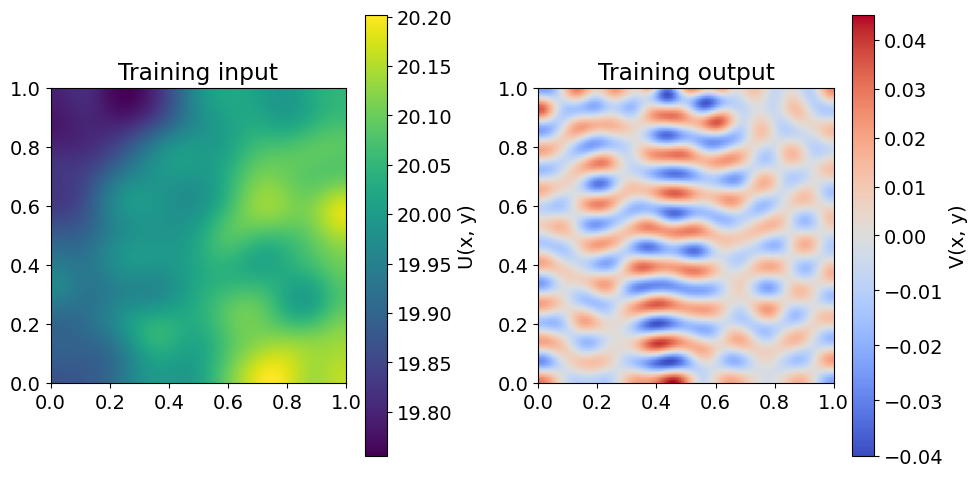

In [23]:
plt.rcParams["lines.linewidth"] = 3
plt.rcParams["font.size"] = 14

index_to_plot = 78

if problem == 'PV_param':
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    ax = ax.flatten()
    im0 = ax[0].imshow(normalise(x_test)[index_to_plot, :s*s].reshape(s, s), origin='lower', extent=extent, cmap=x_cmap, norm=x_norm())
    ax[0].set_title("Lower PV")
    im1 = ax[1].imshow(normalise(x_test)[index_to_plot, s*s:].reshape(s, s), origin='lower', extent=extent, cmap=x_cmap, norm=x_norm())
    ax[1].set_title("Upper PV")
    im2 = ax[2].imshow(normalise(y_test)[index_to_plot, :s*s].reshape(s, s), origin='lower', extent=extent, cmap=y_cmap, norm=y_norm())
    ax[2].set_title("Lower PV Forcing")
    im3 = ax[3].imshow(normalise(y_test)[index_to_plot, s*s:].reshape(s, s), origin='lower', extent=extent, cmap=y_cmap, norm=y_norm())
    ax[3].set_title("Upper PV Forcing")
    fig.colorbar(im0, ax=ax[0])
    fig.colorbar(im1, ax=ax[1])
    fig.colorbar(im2, ax=ax[2])
    fig.colorbar(im3, ax=ax[3])
    plt.tight_layout()
    plt.savefig(f"../figures/{problem}_training_data.pdf")
    plt.show()
else:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    im0 = ax[0].imshow(x_test[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, cmap=x_cmap, norm=x_norm())
    ax[0].set_title("Training input")
    im1 = ax[1].imshow(y_test[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, cmap=y_cmap, norm=y_norm())
    ax[1].set_title("Training output")
    fig.colorbar(im0, ax=ax[0], label=r'U(x, y)')
    fig.colorbar(im1, ax=ax[1], label=r'V(x, y)')
    plt.tight_layout()
    plt.savefig(f"../figures/{problem}_training_data.pdf")
    plt.show()

Define model

In [22]:
import sys
module_dir = '../'
if module_dir not in sys.path:
    sys.path.append(module_dir)
from models import *
import gpjax as gpx

Determine the number of PCs required to capture a given amount of variance (Figures A.1(b-d))

In [16]:
max_possible_pca = min(x_train.shape[0], x_train.shape[1])

large_n = 500 # used as the upper limit of number of PCs to use, set such that it's larger than what's required
x_var_required = 0.9
y_var_required = 0.9

### separate PCAs
x_pca = PCA(n_components = large_n)
x_pca.fit(x_train)

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
ax[0].plot(range(1, len(np.cumsum(x_pca.explained_variance_ratio_))+1)[:], np.cumsum(x_pca.explained_variance_ratio_)[:])
ax[0].set_ylabel('cumulative variance explained')
ax[0].set_xlabel('PCA component')
ax[0].axhline(0.99, color = 'red')
ax[0].axhline(0.95, color = 'red', linestyle = '--')
ax[0].set_title("Training input")

# n = np.where(np.cumsum(x_pca.explained_variance_ratio_) > x_var_required)[0][0]

y_pca = PCA(n_components = large_n)
y_pca.fit(y_train)

ax[1].plot(range(1, len(np.cumsum(y_pca.explained_variance_ratio_))+1)[:], np.cumsum(y_pca.explained_variance_ratio_)[:])
ax[1].set_xlabel('PCA component')
ax[1].axhline(0.99, color = 'red')
ax[1].axhline(0.95, color = 'red', linestyle = '--')
ax[1].set_title("Training output")
plt.tight_layout()
plt.savefig(f"../figures/{problem}_pca_cumsum.pdf")
plt.show()

# m = np.where(np.cumsum(y_pca.explained_variance_ratio_) > y_var_required)[0][0]

# print(f'n, m with individually-trained PCAs: {n, m}')


ValueError: n_components=500 must be between 0 and min(n_samples, n_features)=312 with svd_solver='full'

Experiments with joint PCA (unnecessary for reproducing results and may raise an error)

In [ ]:
### Experimental

### combined PCA (more features)
combined_pca_full = PCA(n_components = max_possible_pca)
combined_pca = PCA(n_components = large_n)
combined_train = np.concatenate((x_train, y_train), axis = 1)
combined_train_pca_full = combined_pca_full.fit_transform(combined_train)
combined_train_pca = combined_pca.fit_transform(combined_train)
print('does combined pca')

x_pca = PCA(n_components = large_n)
x_pca_full = PCA(n_components = max_possible_pca)
y_pca = PCA(n_components = large_n)
y_pca_full = PCA(n_components = max_possible_pca)

x_pca.components_ = combined_pca.components_[:, :x_train.shape[1]]
x_pca_full.components_ = combined_pca_full.components_[:, :x_train.shape[1]]
x_pca.mean_ = combined_pca.mean_[:x_train.shape[1]]
x_pca_full.mean_ = combined_pca_full.mean_[:x_train.shape[1]]

y_pca.components_ = combined_pca.components_[:, x_train.shape[1]:]
y_pca_full.components_ = combined_pca_full.components_[:, x_train.shape[1]:]
y_pca.mean_ = combined_pca.mean_[x_train.shape[1]:]
y_pca_full.mean_ = combined_pca_full.mean_[x_train.shape[1]:]

def compute_eigenvalues(components, original_data):
    # Reconstruct the covariance matrix from the components
    # `components` are the PCA components for either x_pca or y_pca
    # `original_data` should be x_train or y_train as applicable
    transformed_data = original_data @ components.T
    covariance_matrix = np.cov(transformed_data, rowvar=False)
    eigenvalues = np.diag(covariance_matrix)
    total_variance = np.sum(eigenvalues)

    return eigenvalues

def get_total_var(components, original_data):
    transformed_data = original_data @ components.T
    covariance_matrix = np.cov(transformed_data, rowvar=False)
    eigenvalues = np.diag(covariance_matrix)
    total_variance = np.sum(eigenvalues)

    return total_variance

x_eigenvalues = compute_eigenvalues(x_pca.components_, x_train - x_pca.mean_)
y_eigenvalues = compute_eigenvalues(y_pca.components_, y_train - y_pca.mean_)

x_pca.explained_variance_ratio_ = x_eigenvalues / get_total_var(x_pca_full.components_, x_train - x_pca_full.mean_)
y_pca.explained_variance_ratio_ = y_eigenvalues / get_total_var(y_pca_full.components_, y_train - y_pca_full.mean_)

x_pca.explained_variance_ = x_eigenvalues
y_pca.explained_variance_ = y_eigenvalues

plt.plot(combined_pca.explained_variance_)
plt.show()

plt.plot(np.cumsum(combined_pca.explained_variance_ratio_))
plt.axhline(0.99, color = 'red')
plt.axhline(0.95, color = 'red', linestyle = '--')
plt.show()

plt.plot(x_pca.explained_variance_)
plt.show()

plt.plot(np.cumsum(x_pca.explained_variance_ratio_))
plt.axhline(0.99, color = 'red')
plt.axhline(0.95, color = 'red', linestyle = '--')
plt.show()

print(np.cumsum(x_pca.explained_variance_ratio_))

plt.plot(y_pca.explained_variance_)
plt.show()

plt.plot(np.cumsum(y_pca.explained_variance_ratio_))
plt.axhline(0.99, color = 'red')
plt.axhline(0.95, color = 'red', linestyle = '--')
plt.show()

print(np.cumsum(y_pca.explained_variance_ratio_))

# n = np.where(np.cumsum(x_pca.explained_variance_ratio_) > x_var_required)[0][0]
# m = np.where(np.cumsum(y_pca.explained_variance_ratio_) > y_var_required)[0][0]

# print(f'n, m with combined PCA (more features): {n, m}')

# combined PCA (more data)
combined_pca = PCA(n_components = large_n)
combined_train = np.concatenate((x_train, y_train), axis = 0)
print(combined_train.shape)
combined_train_pca = combined_pca.fit_transform(combined_train)

plt.plot(combined_pca.explained_variance_)
plt.show()

plt.plot(np.cumsum(combined_pca.explained_variance_ratio_))
plt.axhline(0.99, color = 'red')
plt.axhline(0.95, color = 'red', linestyle = '--')
plt.show()

# n = np.where(np.cumsum(combined_pca.explained_variance_ratio_) > x_var_required)[0][0]
# m = n

# print(f'n, m with combined PCA (more data): {n, m}')

Fitting individual PCAs to $\boldsymbol{X}$ and $\boldsymbol{Y}$ (Figures A.3, A.4, A.5)

In [ ]:
# fitting individual PCAs to x and y

x_train_pca = PCA(n_components=45).fit(x_train)
y_train_pca = PCA(n_components=35).fit(y_train)

# for thesis ###

if problem == 'PV_param':
    fig, ax = plt.subplots(4, 4, figsize=(20, 20))
    ax = ax.flatten()
    c = 0
    for i in range (0, 120, 4):
        if i in [0, 36, 76, 116]:
            ax[c].imshow(x_train_pca.components_[int(i/4), :s*s].reshape(s, s), origin='lower', extent=extent, cmap='coolwarm')
            ax[c].set_title(f"Lower PV x PCA {int(i/4)+1}")
            ax[c+1].imshow(x_train_pca.components_[int(i/4), s*s:].reshape(s, s), origin='lower', extent=extent, cmap='coolwarm')
            ax[c+1].set_title(f"Upper PV x PCA {int(i/4)+1}")
            ax[c+2].imshow(y_train_pca.components_[int(i/4), :s*s].reshape(s, s), origin='lower', extent=extent, cmap='coolwarm')
            ax[c+2].set_title(f"Lower PV forcing PCA {int(i/4)+1}")
            ax[c+3].imshow(y_train_pca.components_[int(i/4), s*s:].reshape(s, s), origin='lower', extent=extent, cmap='coolwarm')
            ax[c+3].set_title(f"Upper PV forcing PCA {int(i/4)+1}")
            c = c + 4
    plt.tight_layout()
    plt.savefig(f"../figures/{problem}_pca_components.pdf")
    plt.show()
else:
    fig, ax = plt.subplots(4, 4, figsize=(20, 20), sharex=True, sharey=True)
    ax = ax.flatten()

    c = 0
    for i in range(0, 70, 2):
        if i in [0, 8, 18, 28, 38, 48, 58, 68]:
            ax[c].imshow(x_train_pca.components_[int(i/2), :].reshape(s, s), origin='lower', extent=extent, cmap='coolwarm')
            ax[c].set_title(f"Input PC {int(i/2)+1}")
            ax[c+1].imshow(y_train_pca.components_[int(i/2), :].reshape(s, s), origin='lower', extent=extent, cmap='coolwarm')
            ax[c+1].set_title(f"Output PC {int(i/2)+1}")
            c = c + 2
    plt.tight_layout()
    plt.savefig(f"../figures/{problem}_pca_components.pdf")
    plt.show()

###########################

if problem == 'PV_param':
    fig, ax = plt.subplots(7, 8, figsize=(40, 35))
    ax = ax.flatten()
    for i in range (0, 56, 4):
        ax[i].imshow(x_train_pca.components_[int(i/4), :s*s].reshape(s, s), origin='lower', extent=extent, cmap='coolwarm')
        ax[i].set_title(f"Lower PV PCA {int(i/4)+1}")
        ax[i+1].imshow(x_train_pca.components_[int(i/4), s*s:].reshape(s, s), origin='lower', extent=extent, cmap='coolwarm')
        ax[i+1].set_title(f"Upper PV PCA {int(i/4)+1}")
        ax[i+2].imshow(y_train_pca.components_[int(i/4), :s*s].reshape(s, s), origin='lower', extent=extent, cmap='coolwarm')
        ax[i+2].set_title(f"Lower PV forcing PCA {int(i/4)+1}")
        ax[i+3].imshow(y_train_pca.components_[int(i/4), s*s:].reshape(s, s), origin='lower', extent=extent, cmap='coolwarm')
        ax[i+3].set_title(f"Upper PV forcing PCA {int(i/4)+1}")
    plt.tight_layout()
    plt.show()

else:
    fig, ax = plt.subplots(7, 10, figsize=(50, 35))
    ax = ax.flatten()

    for i in range(0, 70, 2):
        ax[i].imshow(x_train_pca.components_[int(i/2), :].reshape(s, s), origin='lower', extent=extent, cmap='coolwarm')
        ax[i].set_title(f"x PCA {int(i/2)+1}")
        ax[i+1].imshow(y_train_pca.components_[int(i/2), :].reshape(s, s), origin='lower', extent=extent, cmap='coolwarm')
        ax[i+1].set_title(f"y PCA {int(i/2)+1}")
    plt.show()

    corr_list = []
    fig, ax = plt.subplots(7, 5, figsize=(25, 35))
    ax = ax.flatten()
    for i in range(0, 35):
        ax[i].plot(x_train_pca.components_[i, :], y_train_pca.components_[i, :], marker='o', linestyle='', alpha = 0.2)
        ax[i].set_xlabel(f"PCA {i+1} x")
        ax[i].set_ylabel(f"PCA {i+1} y")
        ax[i].set_title(f"PCA {i+1} x-y comparison")
        corr_list.append(np.corrcoef(x_train_pca.components_[i, :], y_train_pca.components_[i, :])[0, 1])
    plt.show()

    plt.figure()
    plt.plot(corr_list)
    plt.xlabel('PCA component')
    plt.ylabel('Correlation between x and y')
    plt.show()

    x_train_pca = x_train_pca.transform(x_train)
    y_train_pca = y_train_pca.transform(y_train)

    for i in range(5):
        plt.figure()
        plt.hist(x_train_pca[:, i], bins=50, label = f'x_train_pca {i+1}', alpha=0.5)
        plt.hist(y_train_pca[:, i], bins=50, label = f'y_train_pca {i+1}', alpha=0.5)
        plt.show()

    print('standardising')

    for i in range(5):
        x_train_pca_stand_i = (x_train_pca[:, i] - x_train_pca[:, i].mean(axis = 0))/x_train_pca[:, i].std(axis = 0)
        y_train_pca_stand_i = (y_train_pca[:, i] - y_train_pca[:, i].mean(axis = 0))/y_train_pca[:, i].std(axis = 0)
        plt.figure()
        plt.hist(x_train_pca_stand_i, bins=50, label = f'x_train_pca_stand {i+1}', alpha=0.5)
        plt.hist(y_train_pca_stand_i, bins=50, label = f'y_train_pca_stand {i+1}', alpha=0.5)
        plt.show()


Experiments with joint PCA (unnecessary for reproducing results and may raise an error)

(400, 1682)


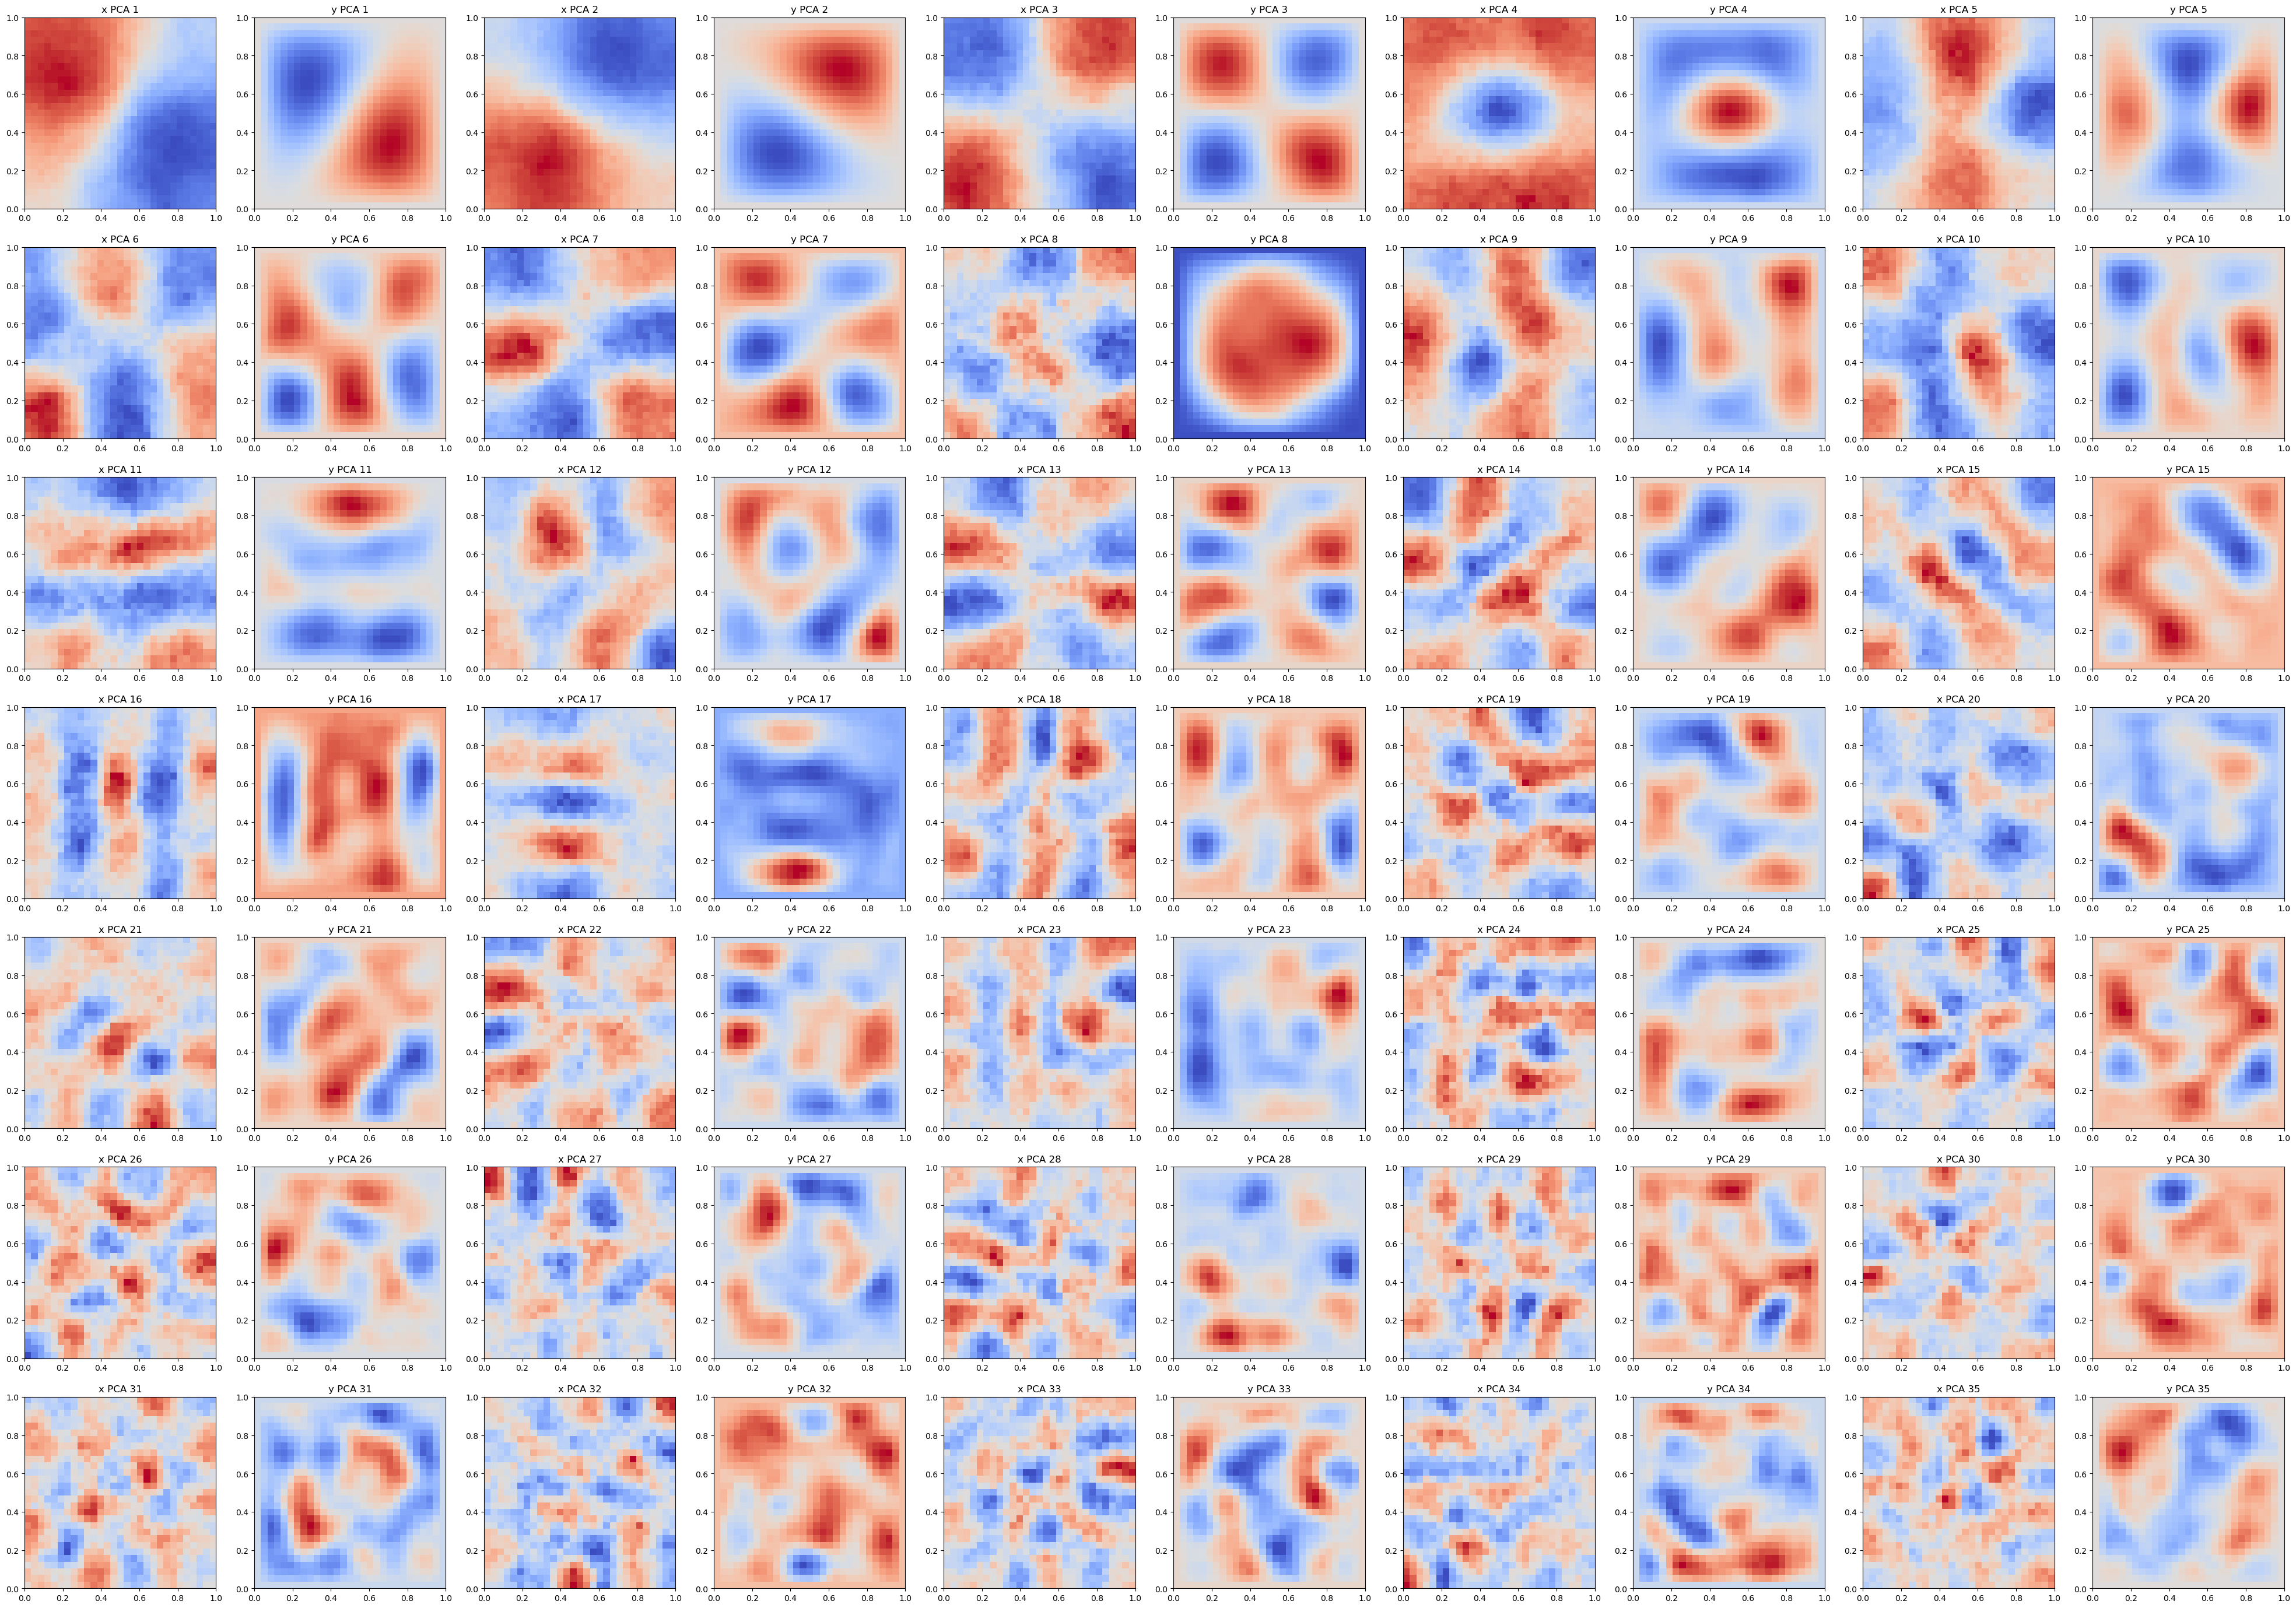

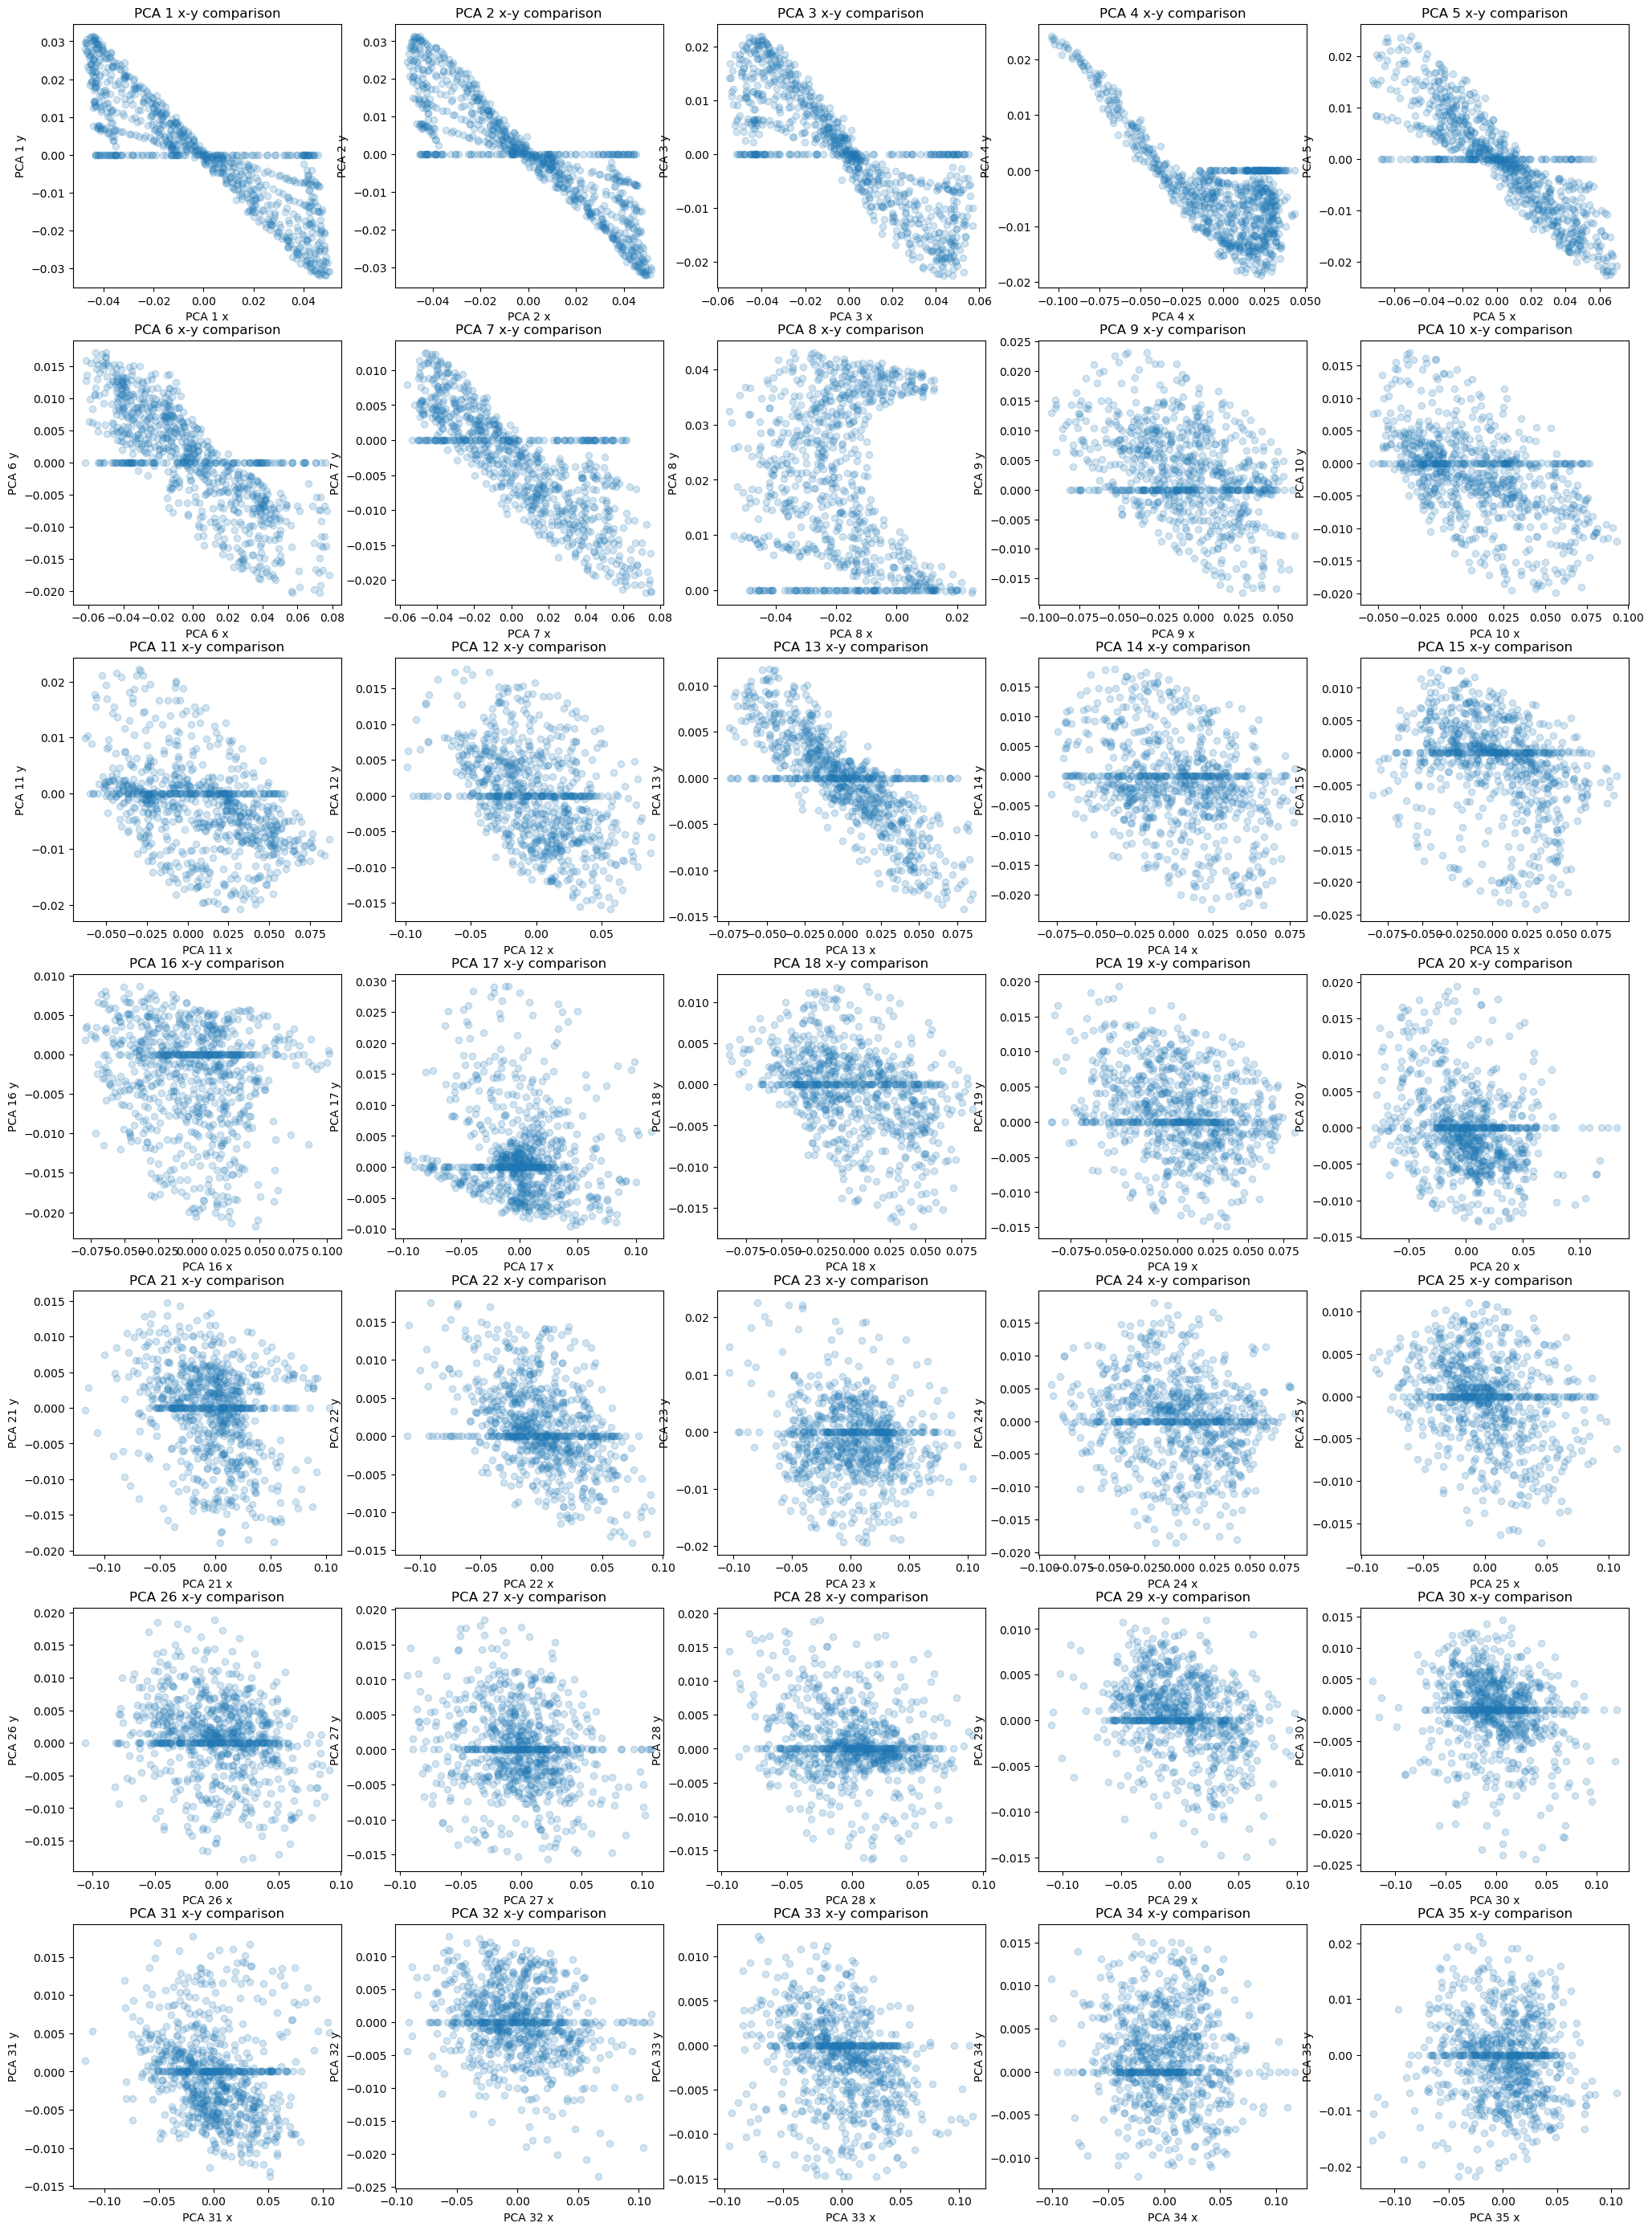

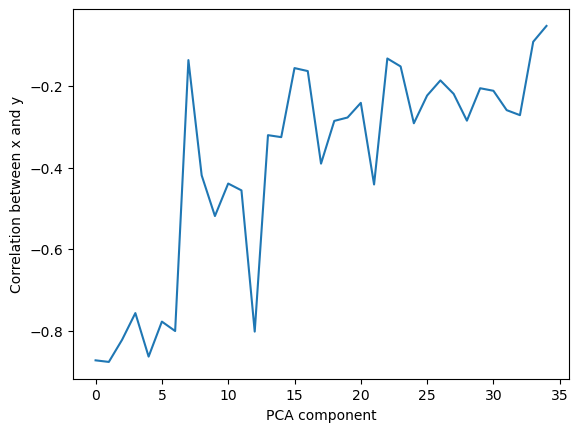

(400, 45)


In [ ]:
# fitting PCA to combined x and y (more features)

combined_train = np.concatenate((x_train, y_train), axis = 1)
print(combined_train.shape)

combined_train_pca = PCA(n_components=45).fit(combined_train)

fig, ax = plt.subplots(7, 10, figsize=(50, 35))
ax = ax.flatten()

for i in range(0, 70, 2):
    ax[i].imshow(combined_train_pca.components_[int(i/2), :x_train.shape[1]].reshape(s, s), origin='lower', extent=extent, cmap='coolwarm')
    ax[i].set_title(f"x PCA {int(i/2)+1}")
    ax[i+1].imshow(combined_train_pca.components_[int(i/2), x_train.shape[1]:].reshape(s, s), origin='lower', extent=extent, cmap='coolwarm')
    ax[i+1].set_title(f"y PCA {int(i/2)+1}")
plt.show()

corr_list = []
fig, ax = plt.subplots(7, 5, figsize=(25, 35))
ax = ax.flatten()
for i in range(0, 35):
    ax[i].plot(combined_train_pca.components_[i, :x_train.shape[1]], combined_train_pca.components_[i, x_train.shape[1]:], marker='o', linestyle='', alpha = 0.2)
    ax[i].set_xlabel(f"PCA {i+1} x")
    ax[i].set_ylabel(f"PCA {i+1} y")
    ax[i].set_title(f"PCA {i+1} x-y comparison")
    corr_list.append(np.corrcoef(combined_train_pca.components_[i, :x_train.shape[1]], combined_train_pca.components_[i, x_train.shape[1]:])[0, 1])
plt.show()

plt.figure()
plt.plot(corr_list)
plt.xlabel('PCA component')
plt.ylabel('Correlation between x and y')
plt.show()

combined_train_pca = combined_train_pca.transform(combined_train)
print(combined_train_pca.shape)

(800, 841)


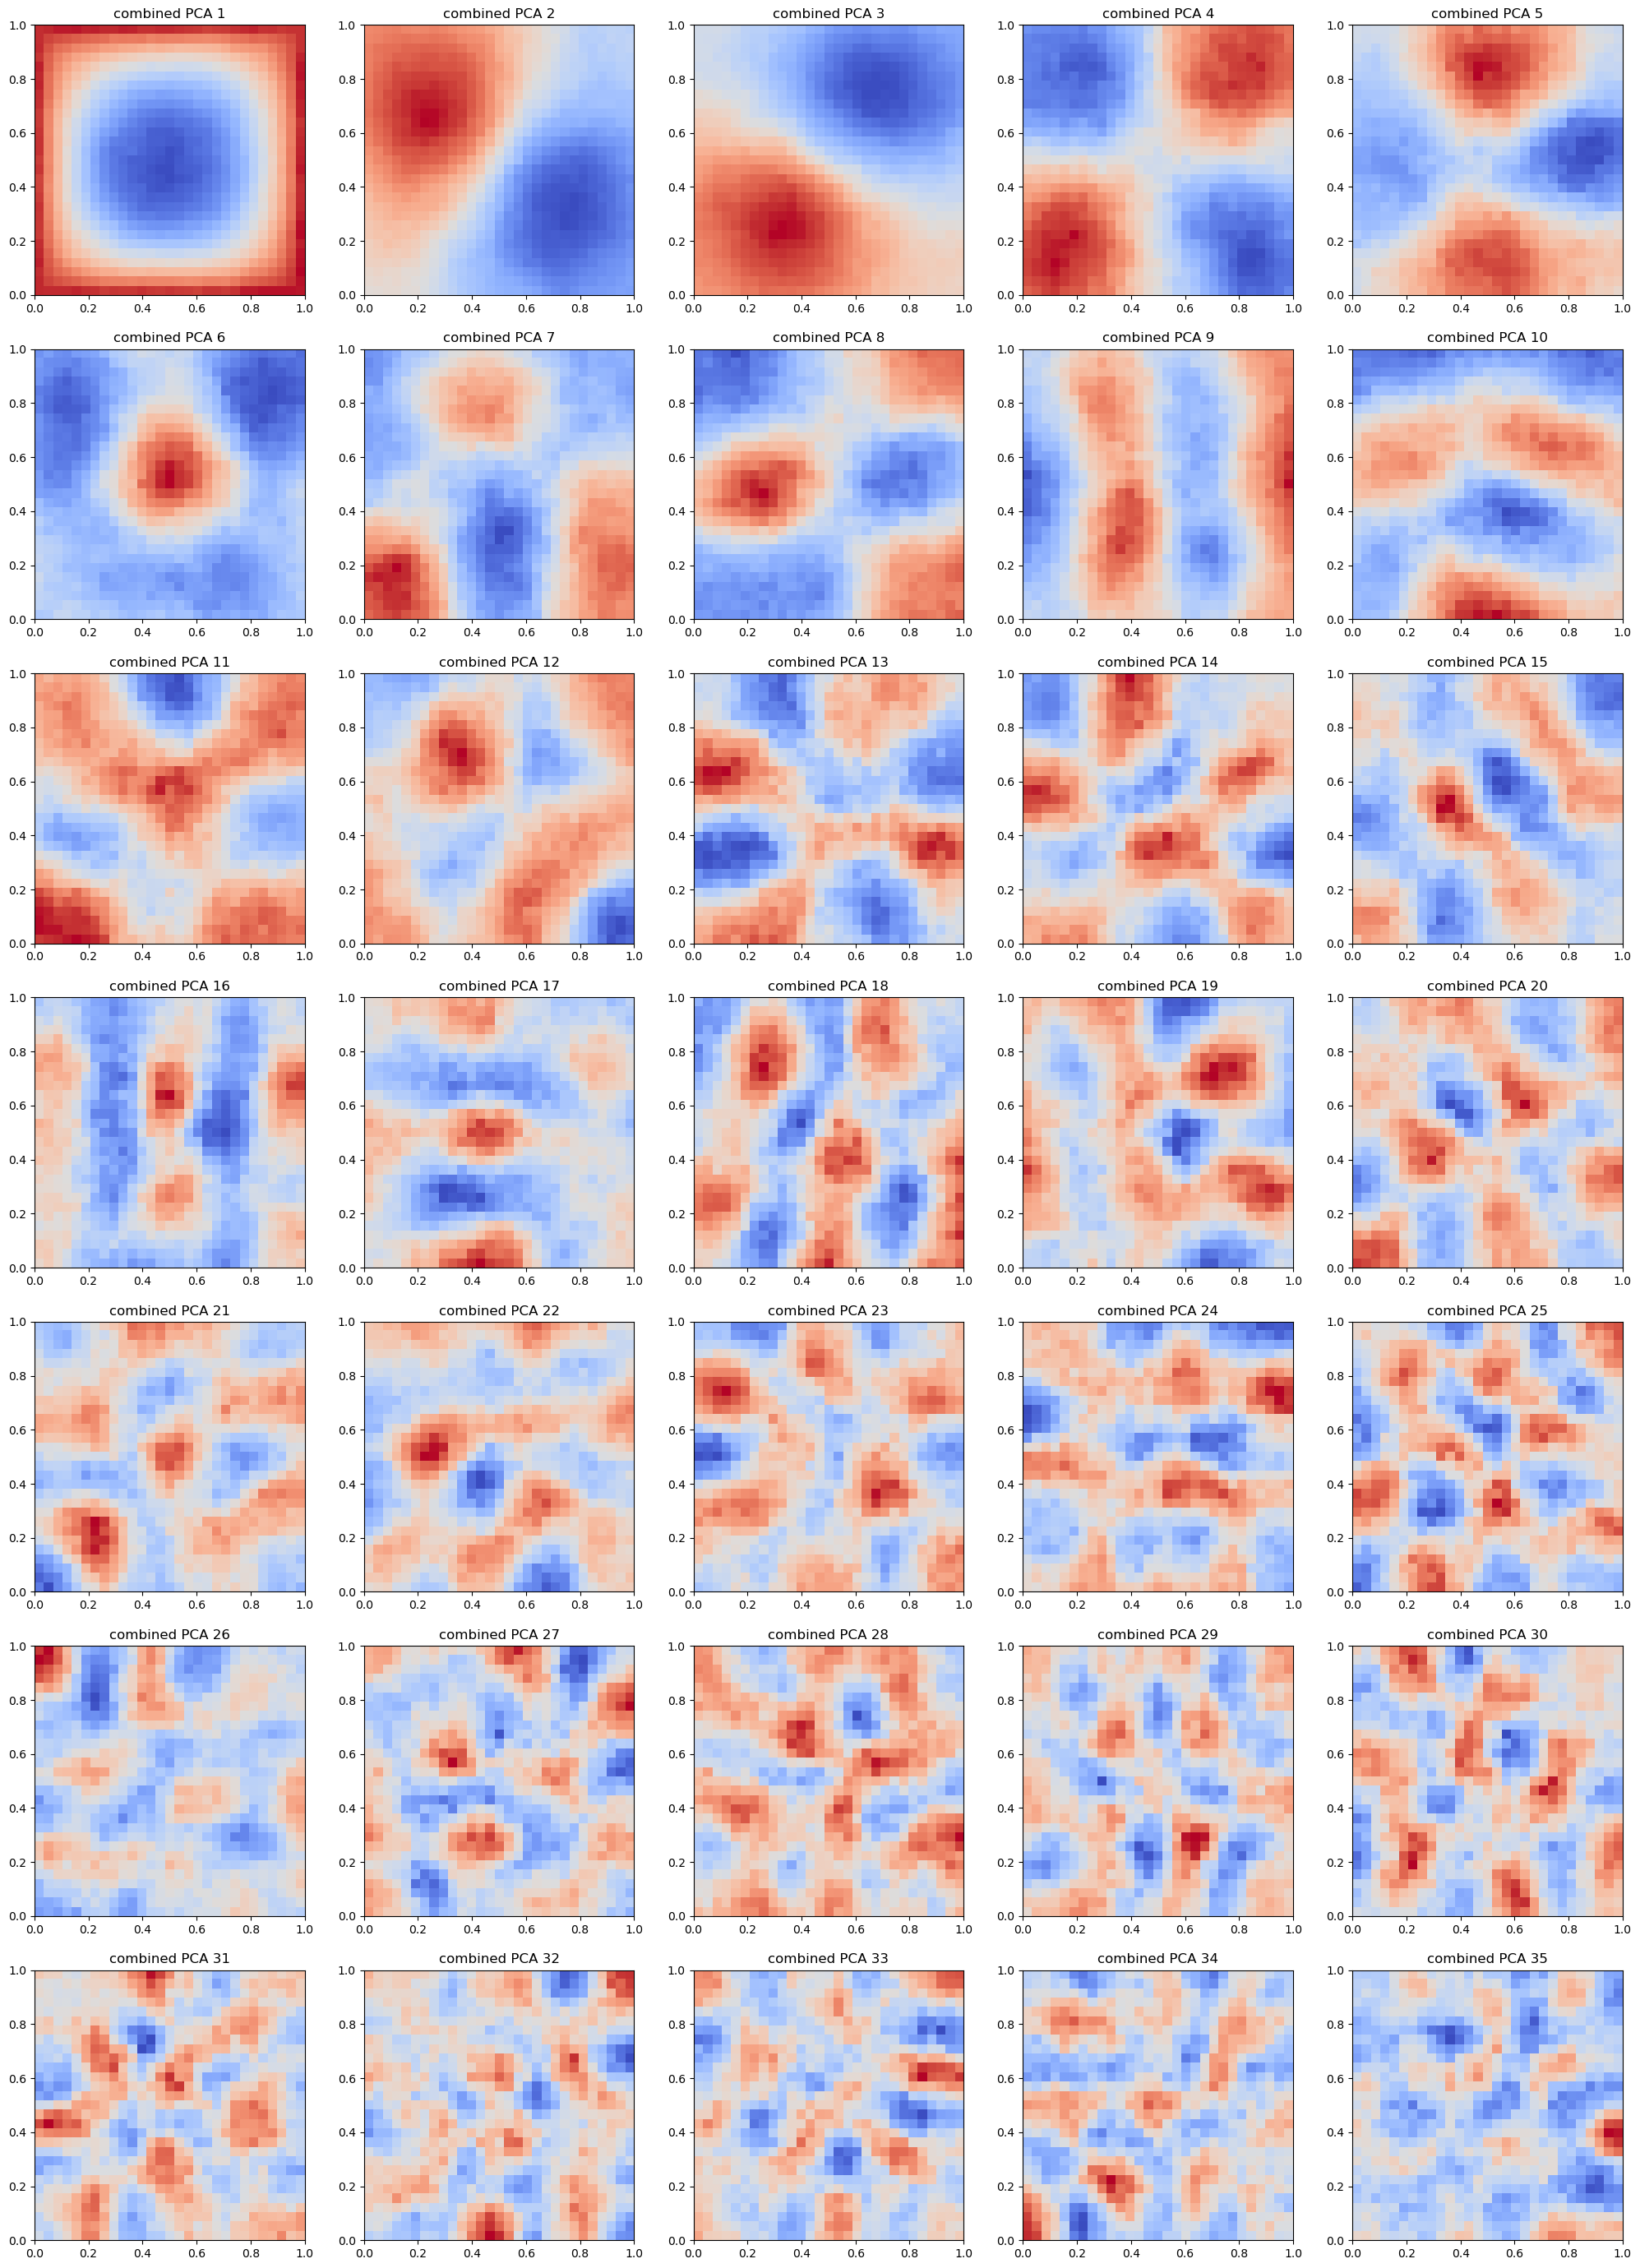

(800, 45)


In [ ]:
# fit PCA to combined x and y (more data)

combined_train = np.concatenate((x_train, y_train), axis = 0)
print(combined_train.shape)

combined_train_pca = PCA(n_components=45).fit(combined_train)

fig, ax = plt.subplots(7, 5, figsize=(25, 35))
ax = ax.flatten()

for i in range(0, 35):
    ax[i].imshow(combined_train_pca.components_[i, :].reshape(s, s), origin='lower', extent=extent, cmap='coolwarm')
    ax[i].set_title(f"combined PCA {i+1}")
plt.show()

combined_train_pca = combined_train_pca.transform(combined_train)
print(combined_train_pca.shape)

In [ ]:
# fitting my custom joint PCA with tunable parameter $\rho$

# parameter
rho = 50
n_components = 5
subset_size = 200
###########

w_opt, result_history, term_history = my_joint_PCA(x_train[:, :subset_size], y_train[:, :subset_size], rho = rho, n_components = n_components)
print(w_opt.shape)

# plotting weights
# fig, ax = plt.subplots(7, 10, figsize=(50, 35))
# ax = ax.flatten()

# for i in range(0, n_components*2, 2):
#     ax[i].imshow(w_opt[int(i/2), :x_train.shape[1]].reshape(s, s), origin='lower', extent=extent, cmap='coolwarm')
#     ax[i].set_title(f"x PCA {int(i/2)+1}")
#     ax[i+1].imshow(w_opt[int(i/2), x_train.shape[1]:].reshape(s, s), origin='lower', extent=extent, cmap='coolwarm')
#     ax[i+1].set_title(f"y PCA {int(i/2)+1}")
# plt.show()

# plotting weight correlations
corr_list = []
fig, ax = plt.subplots(7, 5, figsize=(25, 35))
ax = ax.flatten()
for i in range(0, n_components):
    ax[i].plot(w_opt[i, :x_train[:, :subset_size].shape[1]], w_opt[i, x_train[:, :subset_size].shape[1]:], marker='o', linestyle='', alpha = 0.2)
    ax[i].set_xlabel(f"PCA {i+1} x")
    ax[i].set_ylabel(f"PCA {i+1} y")
    ax[i].set_title(f"PCA {i+1} x-y comparison")
    corr_list.append(np.corrcoef(w_opt[i, :x_train[:, :subset_size].shape[1]], w_opt[i, x_train[:, :subset_size].shape[1]:])[0, 1])
plt.show()

plt.figure()
plt.plot(np.abs(corr_list))
plt.xlabel('PCA component')
plt.ylabel('Correlation between x and y')
plt.show()


 # Train model

 Use parameters provided in Tables A.2 and A.3 to reproduce results.

In [29]:
## Train

n, m = 50, 50

model = full_model(problem = problem, n = n, m = m, ARD = False, multiinput = True, standardise = True, combine_pca = None)
model.fit(x_train, y_train)

does x pca
does y pca


  0%|          | 0/50 [00:00<?, ?it/s]

[1.]
float64


  2%|▏         | 1/50 [00:21<17:52, 21.89s/it]

Optimization terminated successfully.
         Current function value: 617.002620
         Iterations: 25
         Function evaluations: 34
         Gradient evaluations: 34
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.25279149], dtype=float64), variance=Array([2.01528919], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


  4%|▍         | 2/50 [00:41<16:37, 20.78s/it]

Optimization terminated successfully.
         Current function value: 657.771434
         Iterations: 23
         Function evaluations: 34
         Gradient evaluations: 34
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.68248167], dtype=float64), variance=Array([1.74914645], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


  6%|▌         | 3/50 [01:02<16:17, 20.80s/it]

Optimization terminated successfully.
         Current function value: 634.695985
         Iterations: 25
         Function evaluations: 35
         Gradient evaluations: 35
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.75349922], dtype=float64), variance=Array([1.70281166], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


  8%|▊         | 4/50 [01:26<16:55, 22.07s/it]

Optimization terminated successfully.
         Current function value: 635.459170
         Iterations: 26
         Function evaluations: 37
         Gradient evaluations: 37
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.99365589], dtype=float64), variance=Array([1.88277528], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 10%|█         | 5/50 [01:58<19:11, 25.59s/it]

         Current function value: 625.655921
         Iterations: 25
         Function evaluations: 59
         Gradient evaluations: 49
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.99676457], dtype=float64), variance=Array([1.84417098], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


 12%|█▏        | 6/50 [02:20<17:52, 24.37s/it]

Optimization terminated successfully.
         Current function value: 646.698898
         Iterations: 25
         Function evaluations: 33
         Gradient evaluations: 33
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.68577995], dtype=float64), variance=Array([1.70537028], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


 14%|█▍        | 7/50 [02:44<17:19, 24.18s/it]

Optimization terminated successfully.
         Current function value: 643.117193
         Iterations: 26
         Function evaluations: 37
         Gradient evaluations: 37
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.82647419], dtype=float64), variance=Array([1.79248619], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


 16%|█▌        | 8/50 [03:08<16:49, 24.04s/it]

Optimization terminated successfully.
         Current function value: 632.157402
         Iterations: 25
         Function evaluations: 36
         Gradient evaluations: 36
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.06753734], dtype=float64), variance=Array([1.92737126], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


 18%|█▊        | 9/50 [03:31<16:22, 23.96s/it]

Optimization terminated successfully.
         Current function value: 618.854828
         Iterations: 25
         Function evaluations: 33
         Gradient evaluations: 33
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.19475257], dtype=float64), variance=Array([1.97135046], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


 20%|██        | 10/50 [03:53<15:26, 23.16s/it]

Optimization terminated successfully.
         Current function value: 628.829212
         Iterations: 23
         Function evaluations: 31
         Gradient evaluations: 31
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.0235096], dtype=float64), variance=Array([1.87798853], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 22%|██▏       | 11/50 [04:26<17:09, 26.40s/it]

         Current function value: 638.812979
         Iterations: 24
         Function evaluations: 74
         Gradient evaluations: 63
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.16822898], dtype=float64), variance=Array([2.04804402], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 24%|██▍       | 12/50 [05:06<19:13, 30.35s/it]

         Current function value: 637.200289
         Iterations: 27
         Function evaluations: 84
         Gradient evaluations: 71
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.94810903], dtype=float64), variance=Array([1.8571313], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 26%|██▌       | 13/50 [05:48<20:54, 33.90s/it]

         Current function value: 628.157763
         Iterations: 24
         Function evaluations: 79
         Gradient evaluations: 68
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.10030364], dtype=float64), variance=Array([1.93569079], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


 28%|██▊       | 14/50 [06:11<18:23, 30.65s/it]

Optimization terminated successfully.
         Current function value: 643.814654
         Iterations: 24
         Function evaluations: 32
         Gradient evaluations: 32
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.82528821], dtype=float64), variance=Array([1.79148538], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 30%|███       | 15/50 [06:55<20:16, 34.76s/it]

         Current function value: 621.905552
         Iterations: 26
         Function evaluations: 78
         Gradient evaluations: 66
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.24605855], dtype=float64), variance=Array([2.0316223], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


 32%|███▏      | 16/50 [07:20<18:01, 31.82s/it]

Optimization terminated successfully.
         Current function value: 631.342626
         Iterations: 24
         Function evaluations: 34
         Gradient evaluations: 34
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.83802747], dtype=float64), variance=Array([1.75049961], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


 34%|███▍      | 17/50 [07:42<15:47, 28.72s/it]

Optimization terminated successfully.
         Current function value: 631.195135
         Iterations: 23
         Function evaluations: 33
         Gradient evaluations: 33
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.90875936], dtype=float64), variance=Array([1.79922248], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


 36%|███▌      | 18/50 [08:01<13:50, 25.97s/it]

Optimization terminated successfully.
         Current function value: 645.089491
         Iterations: 22
         Function evaluations: 32
         Gradient evaluations: 32
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.69901597], dtype=float64), variance=Array([1.70730769], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


 38%|███▊      | 19/50 [08:26<13:09, 25.45s/it]

Optimization terminated successfully.
         Current function value: 637.141779
         Iterations: 23
         Function evaluations: 31
         Gradient evaluations: 31
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.90405733], dtype=float64), variance=Array([1.82198173], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 40%|████      | 20/50 [09:06<14:57, 29.93s/it]

         Current function value: 644.267276
         Iterations: 22
         Function evaluations: 70
         Gradient evaluations: 58
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.68354656], dtype=float64), variance=Array([1.69375321], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


 42%|████▏     | 21/50 [09:33<14:00, 29.00s/it]

Optimization terminated successfully.
         Current function value: 630.611578
         Iterations: 27
         Function evaluations: 34
         Gradient evaluations: 34
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.02026111], dtype=float64), variance=Array([1.88433065], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


 44%|████▍     | 22/50 [10:00<13:16, 28.44s/it]

Optimization terminated successfully.
         Current function value: 641.160877
         Iterations: 27
         Function evaluations: 34
         Gradient evaluations: 34
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.70927177], dtype=float64), variance=Array([1.69997457], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


 46%|████▌     | 23/50 [10:28<12:40, 28.16s/it]

Optimization terminated successfully.
         Current function value: 634.860049
         Iterations: 27
         Function evaluations: 36
         Gradient evaluations: 36
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.89544015], dtype=float64), variance=Array([1.80569093], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 48%|████▊     | 24/50 [11:03<13:10, 30.41s/it]

         Current function value: 627.871108
         Iterations: 26
         Function evaluations: 77
         Gradient evaluations: 67
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.87325624], dtype=float64), variance=Array([1.75990661], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 50%|█████     | 25/50 [11:31<12:22, 29.69s/it]

         Current function value: 621.729528
         Iterations: 24
         Function evaluations: 52
         Gradient evaluations: 41
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.11094318], dtype=float64), variance=Array([1.9172146], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


 52%|█████▏    | 26/50 [11:52<10:47, 26.97s/it]

Optimization terminated successfully.
         Current function value: 621.783026
         Iterations: 23
         Function evaluations: 30
         Gradient evaluations: 30
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.13312628], dtype=float64), variance=Array([1.93467766], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


 54%|█████▍    | 27/50 [12:12<09:31, 24.86s/it]

Optimization terminated successfully.
         Current function value: 631.817380
         Iterations: 24
         Function evaluations: 33
         Gradient evaluations: 33
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.90600771], dtype=float64), variance=Array([1.80154602], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


 56%|█████▌    | 28/50 [12:31<08:28, 23.10s/it]

Optimization terminated successfully.
         Current function value: 645.963572
         Iterations: 22
         Function evaluations: 33
         Gradient evaluations: 33
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.68565815], dtype=float64), variance=Array([1.7014533], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


 58%|█████▊    | 29/50 [12:49<07:36, 21.73s/it]

Optimization terminated successfully.
         Current function value: 627.603480
         Iterations: 23
         Function evaluations: 30
         Gradient evaluations: 30
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.0601227], dtype=float64), variance=Array([1.90425393], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 60%|██████    | 30/50 [13:23<08:26, 25.32s/it]

         Current function value: 601.822581
         Iterations: 22
         Function evaluations: 87
         Gradient evaluations: 75
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.45433506], dtype=float64), variance=Array([2.11622921], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


 62%|██████▏   | 31/50 [13:47<07:54, 24.98s/it]

Optimization terminated successfully.
         Current function value: 634.740064
         Iterations: 25
         Function evaluations: 51
         Gradient evaluations: 49
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.88028571], dtype=float64), variance=Array([1.79568843], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


 64%|██████▍   | 32/50 [14:04<06:47, 22.63s/it]

Optimization terminated successfully.
         Current function value: 630.383585
         Iterations: 23
         Function evaluations: 32
         Gradient evaluations: 32
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.8894262], dtype=float64), variance=Array([1.78208059], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


 66%|██████▌   | 33/50 [14:22<05:58, 21.09s/it]

Optimization terminated successfully.
         Current function value: 653.053223
         Iterations: 23
         Function evaluations: 31
         Gradient evaluations: 31
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.65305216], dtype=float64), variance=Array([1.70812719], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


 68%|██████▊   | 34/50 [14:41<05:26, 20.39s/it]

Optimization terminated successfully.
         Current function value: 626.649074
         Iterations: 25
         Function evaluations: 33
         Gradient evaluations: 33
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.06347134], dtype=float64), variance=Array([1.90216014], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


 70%|███████   | 35/50 [15:01<05:07, 20.51s/it]

Optimization terminated successfully.
         Current function value: 628.186895
         Iterations: 27
         Function evaluations: 34
         Gradient evaluations: 34
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.99898902], dtype=float64), variance=Array([1.85876612], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


 72%|███████▏  | 36/50 [15:20<04:41, 20.08s/it]

Optimization terminated successfully.
         Current function value: 641.761516
         Iterations: 23
         Function evaluations: 34
         Gradient evaluations: 34
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.76410109], dtype=float64), variance=Array([1.7385471], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


 74%|███████▍  | 37/50 [15:39<04:15, 19.62s/it]

Optimization terminated successfully.
         Current function value: 619.133380
         Iterations: 23
         Function evaluations: 33
         Gradient evaluations: 33
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.04680563], dtype=float64), variance=Array([1.85306087], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


 76%|███████▌  | 38/50 [15:57<03:51, 19.26s/it]

Optimization terminated successfully.
         Current function value: 618.537949
         Iterations: 23
         Function evaluations: 34
         Gradient evaluations: 34
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.98321134], dtype=float64), variance=Array([1.80106187], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


 78%|███████▊  | 39/50 [16:19<03:40, 20.02s/it]

Optimization terminated successfully.
         Current function value: 635.334193
         Iterations: 28
         Function evaluations: 39
         Gradient evaluations: 39
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.98453971], dtype=float64), variance=Array([1.87671012], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


 80%|████████  | 40/50 [16:49<03:48, 22.88s/it]

Optimization terminated successfully.
         Current function value: 642.168186
         Iterations: 24
         Function evaluations: 71
         Gradient evaluations: 69
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.74841689], dtype=float64), variance=Array([1.73014775], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


 82%|████████▏ | 41/50 [17:06<03:11, 21.31s/it]

Optimization terminated successfully.
         Current function value: 640.652877
         Iterations: 22
         Function evaluations: 32
         Gradient evaluations: 32
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.7143799], dtype=float64), variance=Array([1.69831585], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


 84%|████████▍ | 42/50 [17:26<02:47, 20.88s/it]

Optimization terminated successfully.
         Current function value: 616.812902
         Iterations: 24
         Function evaluations: 38
         Gradient evaluations: 38
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.07121835], dtype=float64), variance=Array([1.86134904], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 86%|████████▌ | 43/50 [18:16<03:26, 29.55s/it]

         Current function value: 640.291675
         Iterations: 29
         Function evaluations: 138
         Gradient evaluations: 123
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.84911703], dtype=float64), variance=Array([1.79295951], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


 88%|████████▊ | 44/50 [18:33<02:34, 25.69s/it]

Optimization terminated successfully.
         Current function value: 643.401137
         Iterations: 23
         Function evaluations: 30
         Gradient evaluations: 30
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.74785361], dtype=float64), variance=Array([1.73642905], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


 90%|█████████ | 45/50 [19:00<02:10, 26.03s/it]

Optimization terminated successfully.
         Current function value: 614.811335
         Iterations: 25
         Function evaluations: 62
         Gradient evaluations: 61
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.21955589], dtype=float64), variance=Array([1.9743926], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


 92%|█████████▏| 46/50 [19:19<01:36, 24.16s/it]

Optimization terminated successfully.
         Current function value: 625.149913
         Iterations: 25
         Function evaluations: 35
         Gradient evaluations: 35
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.16002925], dtype=float64), variance=Array([1.97539027], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 94%|█████████▍| 47/50 [19:56<01:23, 27.78s/it]

         Current function value: 627.678794
         Iterations: 25
         Function evaluations: 87
         Gradient evaluations: 75
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.86152062], dtype=float64), variance=Array([1.75241204], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


 96%|█████████▌| 48/50 [20:17<00:51, 25.72s/it]

Optimization terminated successfully.
         Current function value: 633.820217
         Iterations: 25
         Function evaluations: 32
         Gradient evaluations: 32
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.89288345], dtype=float64), variance=Array([1.80010036], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


 98%|█████████▊| 49/50 [20:36<00:23, 23.89s/it]

Optimization terminated successfully.
         Current function value: 626.777711
         Iterations: 25
         Function evaluations: 33
         Gradient evaluations: 33
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.04121821], dtype=float64), variance=Array([1.88333146], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]
[1.]
float64


100%|██████████| 50/50 [20:54<00:00, 25.09s/it]

Optimization terminated successfully.
         Current function value: 641.663735
         Iterations: 23
         Function evaluations: 33
         Gradient evaluations: 33
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.959986], dtype=float64), variance=Array([1.88607144], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=860, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))
[2.]
[1.]


test on training data

(860, 4608, 6)
median relative L2 (train data): 0.9352106390298933
mean relative L2 (train data): 55.632260528589335
median R2 (train data): 0.12538098819825533
mean R2 (train data): -29203.623713360706
index of best R2: 322


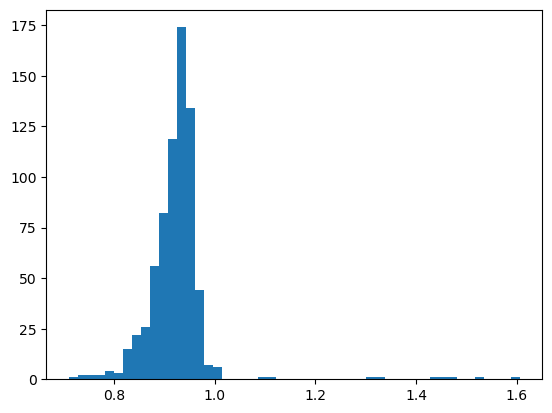

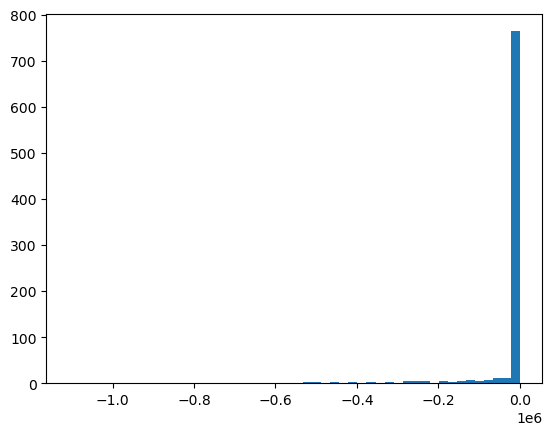

In [52]:
n_samples = 6

y_pred_train, train_samples = model.predict(x_train, n_samples = n_samples)

print(train_samples.shape)

relative_L2 = np.linalg.norm(y_pred_train - y_train, axis = -1)/np.linalg.norm(y_train, axis = -1)
R2 = [r2_score(y_train[i, :], y_pred_train[i, :]) for i in range(y_train.shape[0])]

print(f'median relative L2 (train data): {np.median(relative_L2)}')
print(f'mean relative L2 (train data): {np.mean(relative_L2)}')

print(f'median R2 (train data): {np.median(R2)}')
print(f'mean R2 (train data): {np.mean(R2)}')

print(f'index of best R2: {np.argmax(R2)}')

plt.hist(relative_L2[relative_L2<2], bins = 50)
plt.show()

plt.hist(R2, bins = 50)
plt.show()

Plotting latent space predictions on training data

(156, 10201, 6)


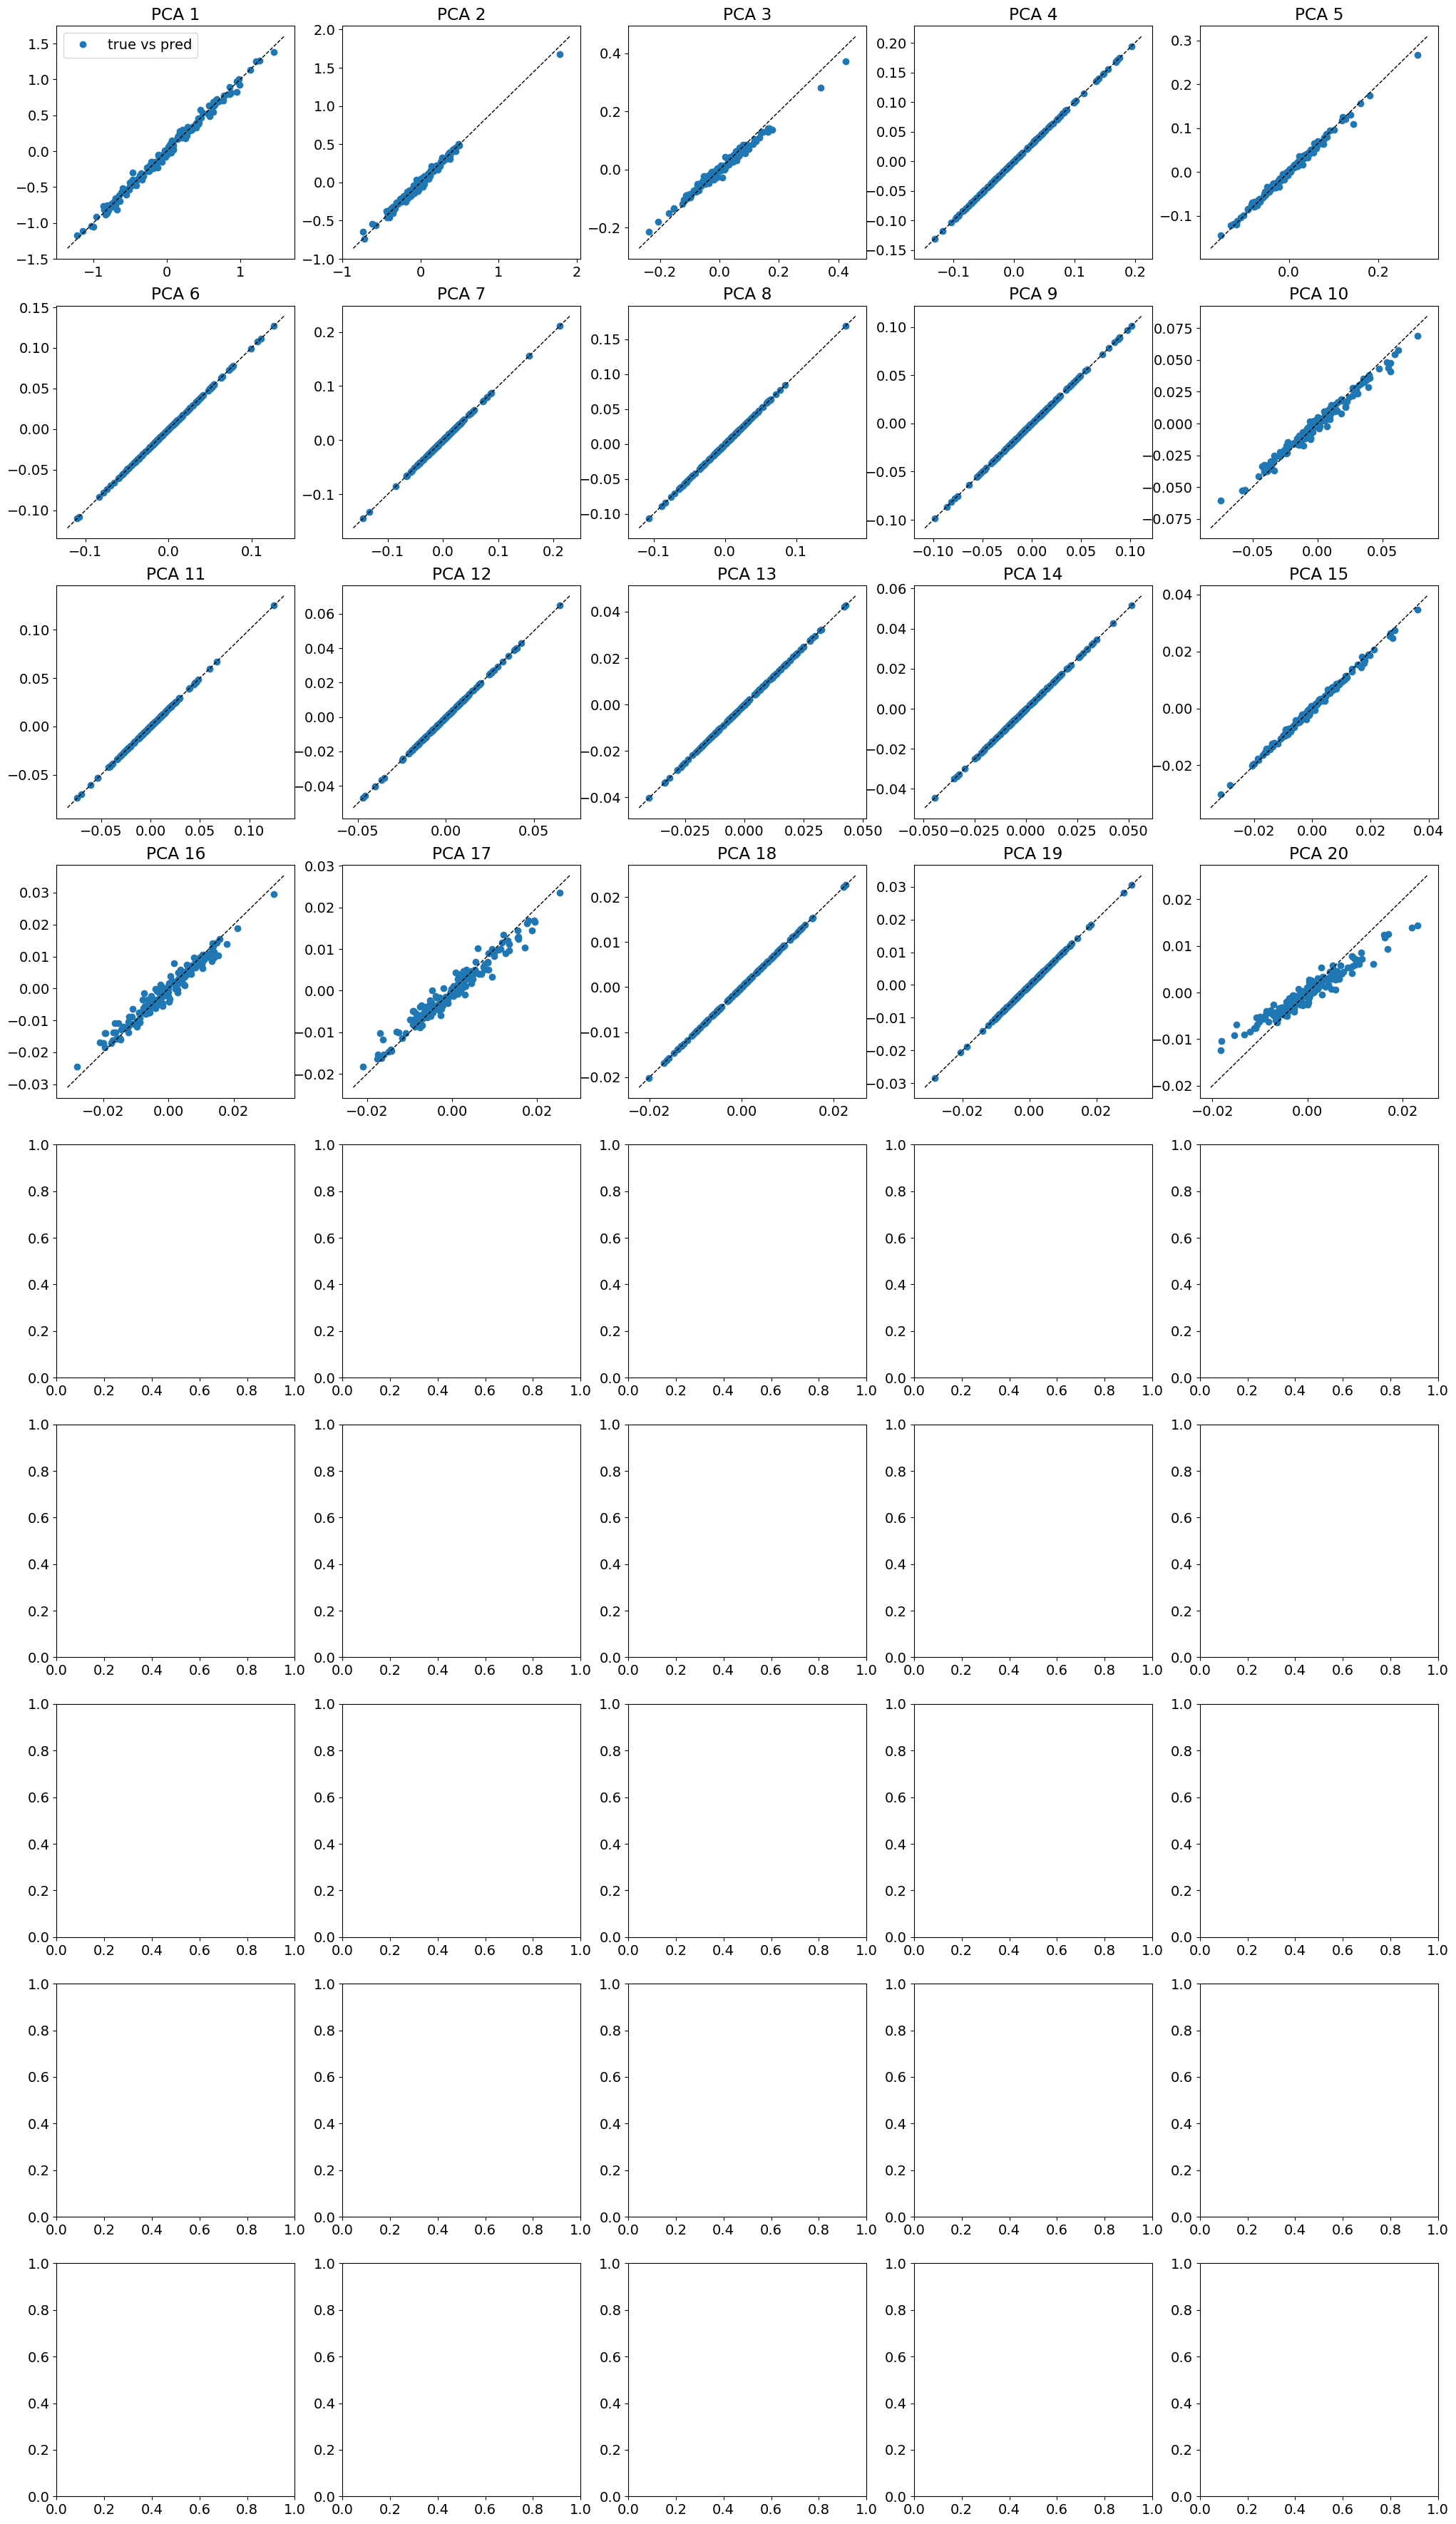

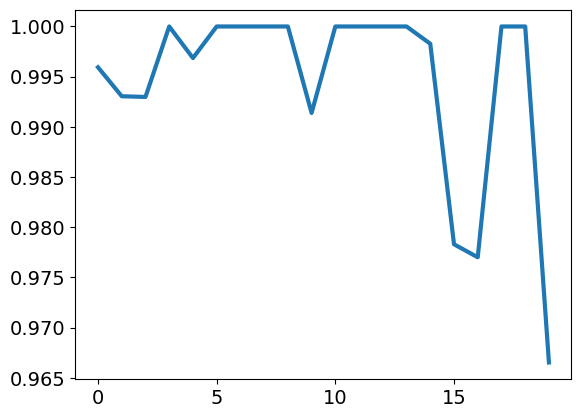

In [ ]:
x_train_pca = model.x_test_pca
y_train_pca = model.y_pca.transform(y_train)

fig, ax = plt.subplots(9, 5, figsize=(25, 45))
ax = ax.flatten()

print(train_samples.shape)

for i in range(m):
    # ax[i].plot(x_train_pca[:, i], y_train_pca[:, i], 'o', label = 'true')
    # ax[i].plot(x_train_pca[:, i][np.argsort(x_train_pca[:, i])], model.y_pred_pca[:, 0, i][np.argsort(x_train_pca[:, i])], '-', label = 'pred', lw = 4)
    # for j in range(n_samples):
    #     train_samples_pca_j = train_samples[:, :, j]
    #     train_samples_j = model.y_pca.transform(train_samples_pca_j)
    #     ax[i].plot(x_train_pca[:, i][np.argsort(x_train_pca[:, i])], train_samples_j[:, i][np.argsort(train_samples_j[:, i])], '-', label = f'sample {j+1}')
    if i > 44:
        break
    ax[i].plot(y_train_pca[:, i], model.y_pred_pca[:, 0, i], 'o', label = 'true vs pred')
    ax[i].set_title(f'PCA {i+1}')

    xlim = ax[i].get_xlim()
    ylim = ax[i].get_ylim()

    min_val = min(xlim[0], ylim[0])
    max_val = max(xlim[1], ylim[1])

    ax[i].plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)
    ax[i].set_title(f'PCA {i+1}')
ax[0].legend()
plt.show()

plt.plot([np.corrcoef(y_train_pca[:, i], model.y_pred_pca[:, 0, i])[0, 1] for i in range(m)])

Plot example training result (Figure 4.7)

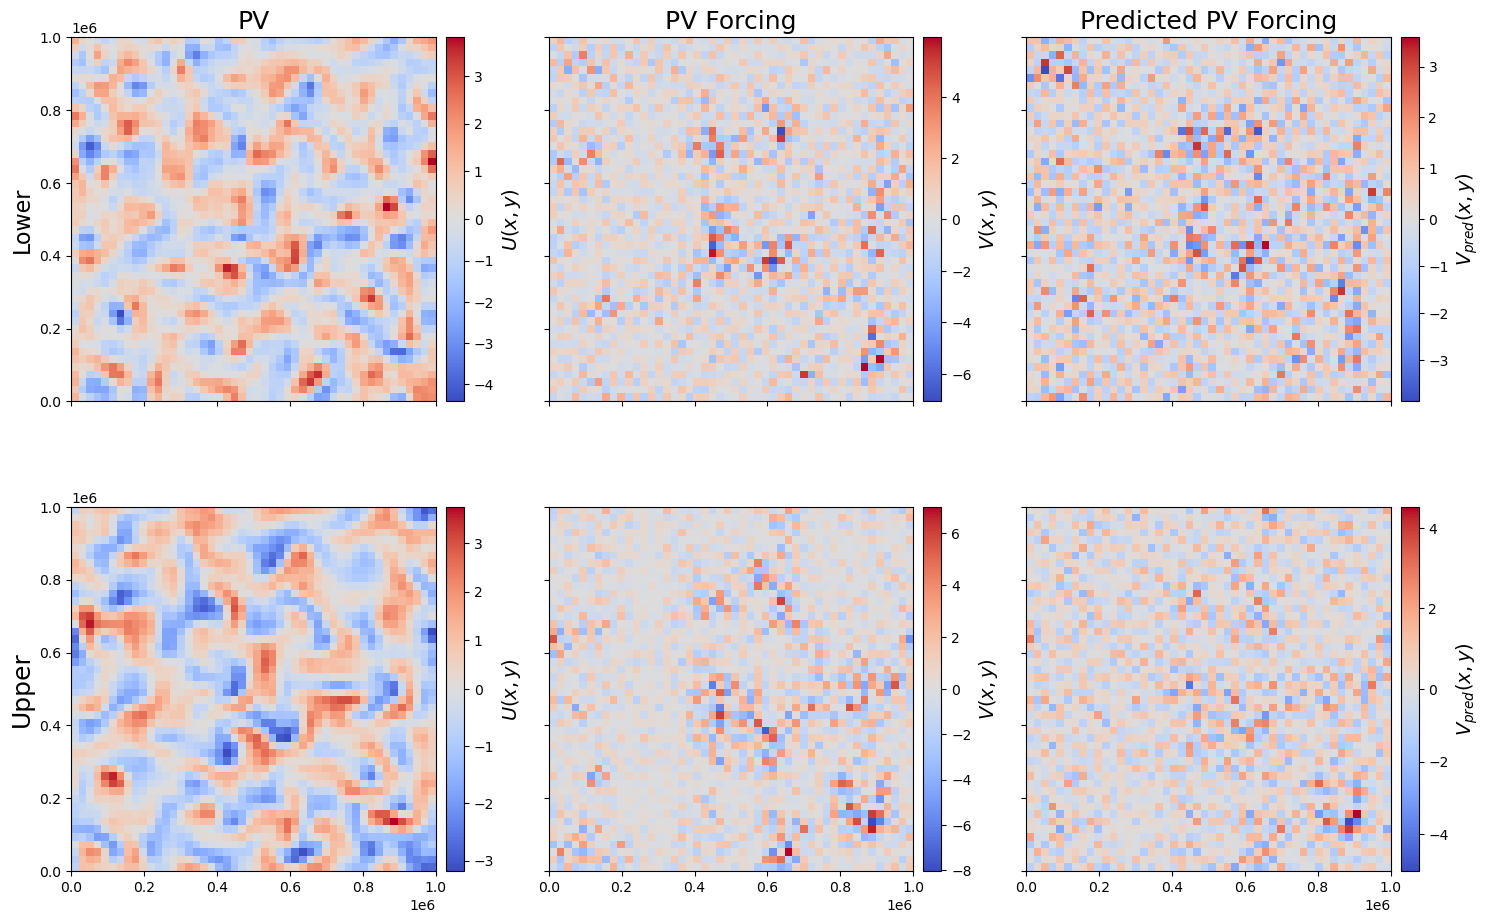

In [66]:
index_to_plot = 322

y_lims = np.array([min(y_test[index_to_plot, :].min(), y_pred_train[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), y_pred_train[index_to_plot, :].max())])

if problem == 'PV_param':
    fig, ax = plt.subplots(2, 3, figsize = (15, 10), sharex=True, sharey=True)
    ax = ax.flatten()

    im0 = ax[0].imshow(x_train[index_to_plot, :s*s].reshape(s, s), origin='lower', extent=extent, norm=x_norm(), cmap = x_cmap)
    ax[0].set_title("PV", fontsize = 18)
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im0, cax=cax).set_label(label=r'$U(x, y)$', size=14)
    ax[0].set_ylabel("Lower", fontsize = 16)
    
    im1 = ax[1].imshow(y_train[index_to_plot, :s*s].reshape(s, s), origin='lower', extent=extent, norm=y_norm(), cmap = y_cmap)
    ax[1].set_title("PV Forcing", fontsize = 18)
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im1, cax=cax).set_label(label=r'$V(x, y)$', size=14)

    im2 = ax[2].imshow(y_pred_train[index_to_plot, :s*s].reshape(s, s), origin='lower', extent=extent, norm=y_norm(), cmap = y_cmap)
    ax[2].set_title("Predicted PV Forcing", fontsize = 18)
    divider = make_axes_locatable(ax[2])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im2, cax=cax).set_label(label=r'$V_{pred}(x, y)$', size=14)

    im3 = ax[3].imshow(x_train[index_to_plot, s*s:].reshape(s, s), origin='lower', extent=extent, norm=x_norm(), cmap = x_cmap)
    divider = make_axes_locatable(ax[3])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im3, cax=cax).set_label(label=r'$U(x, y)$', size=14)
    ax[3].set_ylabel("Upper", fontsize = 18)

    im4 = ax[4].imshow(y_train[index_to_plot, s*s:].reshape(s, s), origin='lower', extent=extent, norm=y_norm(), cmap = y_cmap)
    divider = make_axes_locatable(ax[4])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im4, cax=cax).set_label(label=r'$V(x, y)$', size=14)

    im5 = ax[5].imshow(y_pred_train[index_to_plot, s*s:].reshape(s, s), origin='lower', extent=extent, norm=y_norm(), cmap = y_cmap)
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im5, cax=cax).set_label(label=r'$V_{pred}(x, y)$', size=14)

    plt.tight_layout()
    plt.savefig(f"../figures/{problem}_train_result.pdf")
    plt.show()


else:
    fig, ax = plt.subplots(3, 3, figsize = (15, 15))
    ax = ax.flatten()
    im0 = ax[0].imshow(x_train[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, norm=x_norm(), cmap = x_cmap)
    ax[0].set_title("x_train")
    fig.colorbar(im0, ax=ax[0])
    im1 = ax[1].imshow(y_train[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, norm=y_norm(), cmap = y_cmap)
    ax[1].set_title("y_train")
    fig.colorbar(im1, ax=ax[1])
    im2 = ax[2].imshow(y_pred_train[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, norm=y_norm(), cmap = y_cmap)
    ax[2].set_title("y_pred_train")
    fig.colorbar(im2, ax=ax[2])
    for i in range(6):
        imi = ax[i+3].imshow(train_samples[index_to_plot, :, i].reshape(s, s), origin='lower', extent=extent, norm=y_norm(), cmap = y_cmap)
        ax[i+3].set_title(f"sample {i+1}")
        fig.colorbar(imi, ax=ax[i+3])
        
                # ax[i].legend()
    plt.show()


# Testing

[-929221.4603940009, -746634.9138246843, -558372.8908023227, -456987.52999311284, -312084.47696925723, -225973.5956595399, -149244.58070475177, -101445.96569169912, -61764.73253189957, -35119.662397185886, -19001.10453128382, -8217.425669924505, -3896.57518477031, -1461.0812448626407, -378.799817229132, -14.674105801325888, -0.32248466112523744, -0.005026339679671921, -0.017065204415389834, -0.012911735089530696, -0.010410570099703698, -0.009398094979398142, -0.0004539817423874215, -0.016895642168007985, -0.012871645137245924, -0.004878531488506699, -0.021201645103939182, -0.011547508694248476, -0.027932349836005566, -0.010554831305557899, -0.02474407712250848, -0.0217209337574662, -0.031059504746087985, -0.02412600199379189, -0.018210424209048615, -0.012194346439291515, -0.0125212137696733, -0.027903992625552654, -0.022900663394440635, -0.013830116985537932, -0.006768696145865727, -0.01274285581968937, -0.024618783651533693, -0.010645082688109042, -0.013831131071157854, -0.01555250114

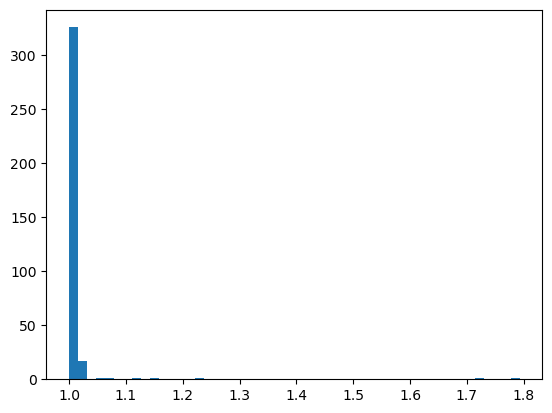

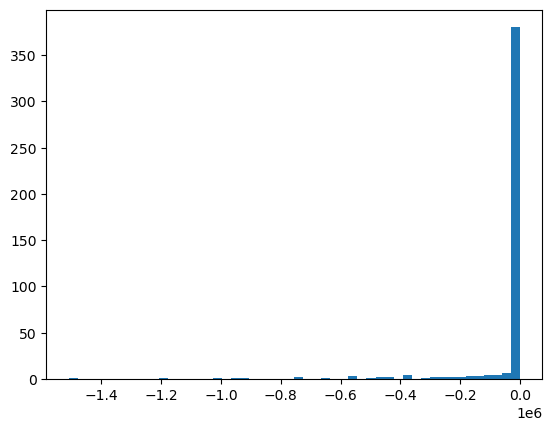

In [51]:
n_samples = 100

y_pred_test, test_samples = model.predict(x_test, n_samples = n_samples)

relative_L2 = np.linalg.norm(y_pred_test - y_test, axis = -1) / np.linalg.norm(y_test, axis = -1)
R2 = [r2_score(y_test[i, :], y_pred_test[i, :]) for i in range(y_test.shape[0])]

print(f'median relative L2: {np.median(relative_L2)}')
print(f'mean relative L2: {np.mean(relative_L2)}')

print(f'median R2: {np.median(R2)}')
print(f'mean R2: {np.mean(R2)}')

plt.hist(relative_L2[relative_L2<2], bins = 50)
plt.show()

plt.hist(R2, bins = 50)
plt.show()


Plotting latent space predictions on testing data (Figures A.6, A.7, A.8)

(156, 10201, 6)
(-1.7523588692544516, 1.6799323965984874) (-2.139828786517757, 1.8825628138190398)
(-0.7561312947971659, 0.9885661282684611) (-1.033952656273795, 0.9354232496594548)
(-0.3107730131117675, 0.3590091419106919) (-0.3028223527205534, 0.26697934261280354)
(-0.13721312989424375, 0.49012645163707974) (-0.2291420531626355, 0.2902647252993188)
(-0.17374646101592198, 0.2599648178327848) (-0.23376783633051285, 0.24777948404578448)
(-0.1289787854797555, 0.12361357613122861) (-0.14107218344525307, 0.14028108317351343)
(-0.16478093451050074, 0.17260537215336733) (-0.18994740322300308, 0.16071563008770548)
(-0.20401495836688516, 0.22191852045369842) (-0.1320415803268395, 0.1724894149218784)
(-0.16338973887220082, 0.14062946910745142) (-0.11970649569880815, 0.12173759847986262)
(-0.10962579986239113, 0.09914832932752479) (-0.09968511776871011, 0.11312676691027712)
(-0.10295032065633038, 0.12888730069243243) (-0.08436181282830268, 0.08619772782895616)
(-0.12708442404071593, 0.0763588014

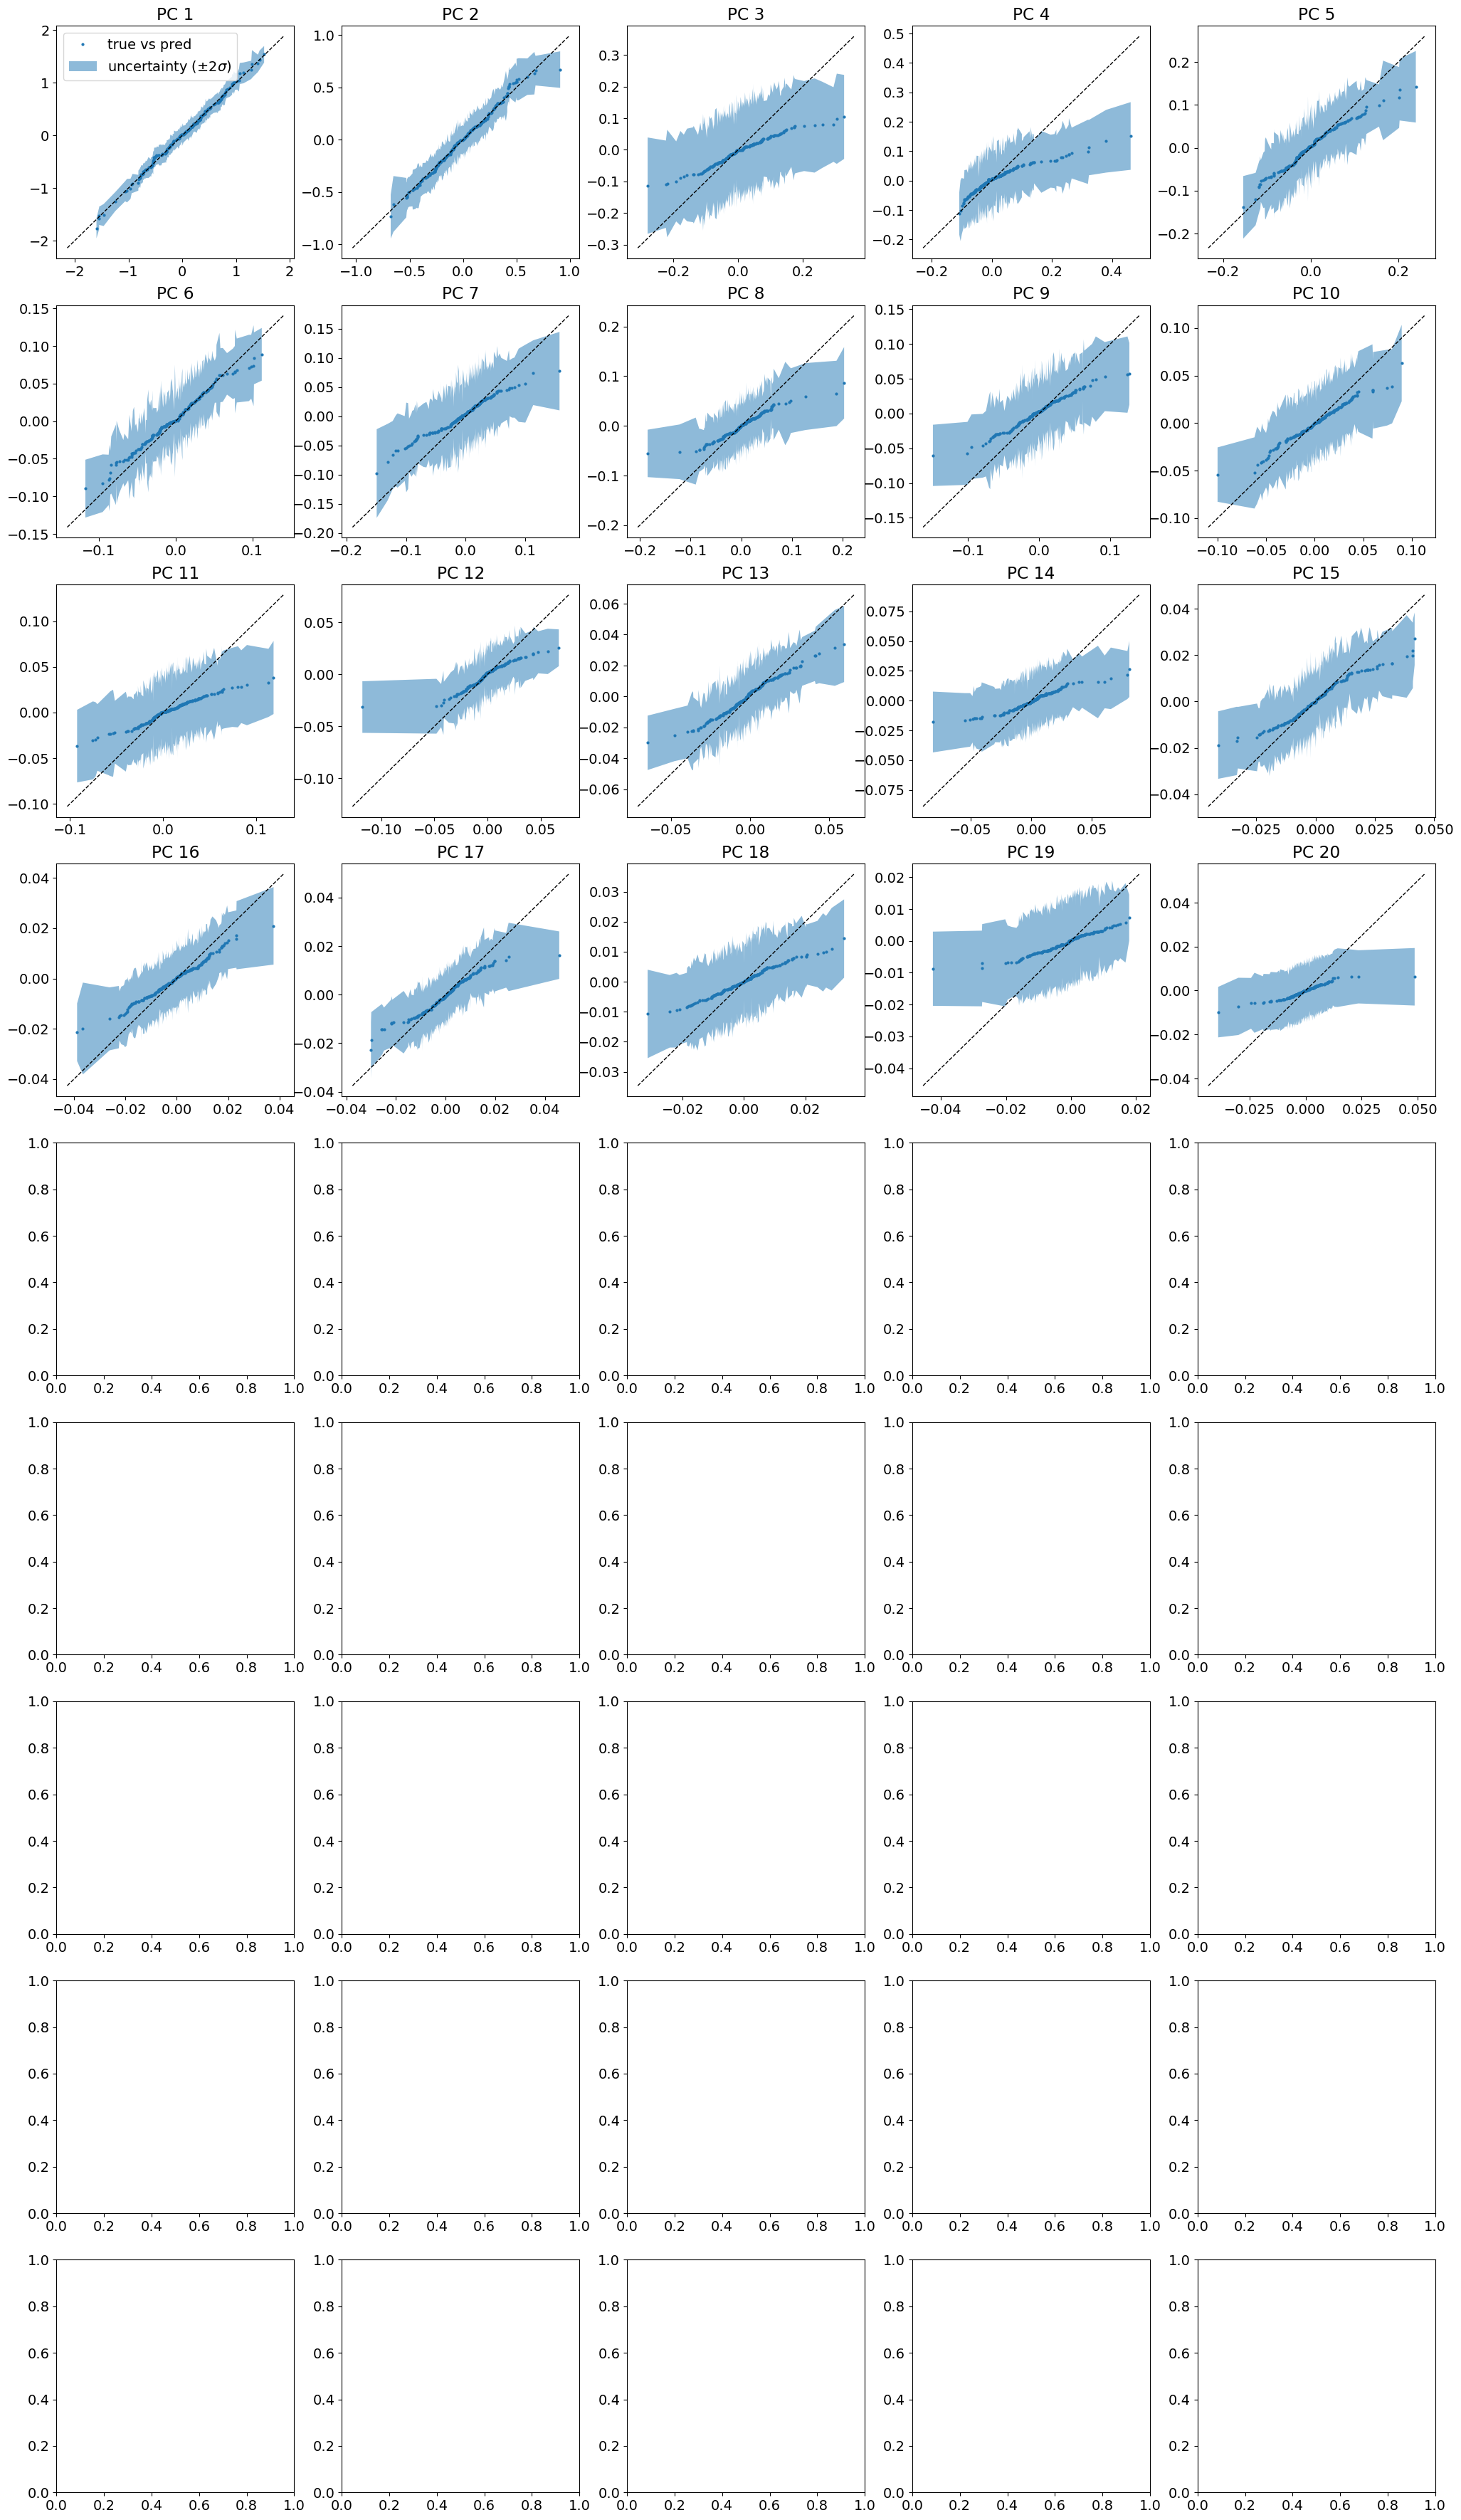

(156, 10201, 6)


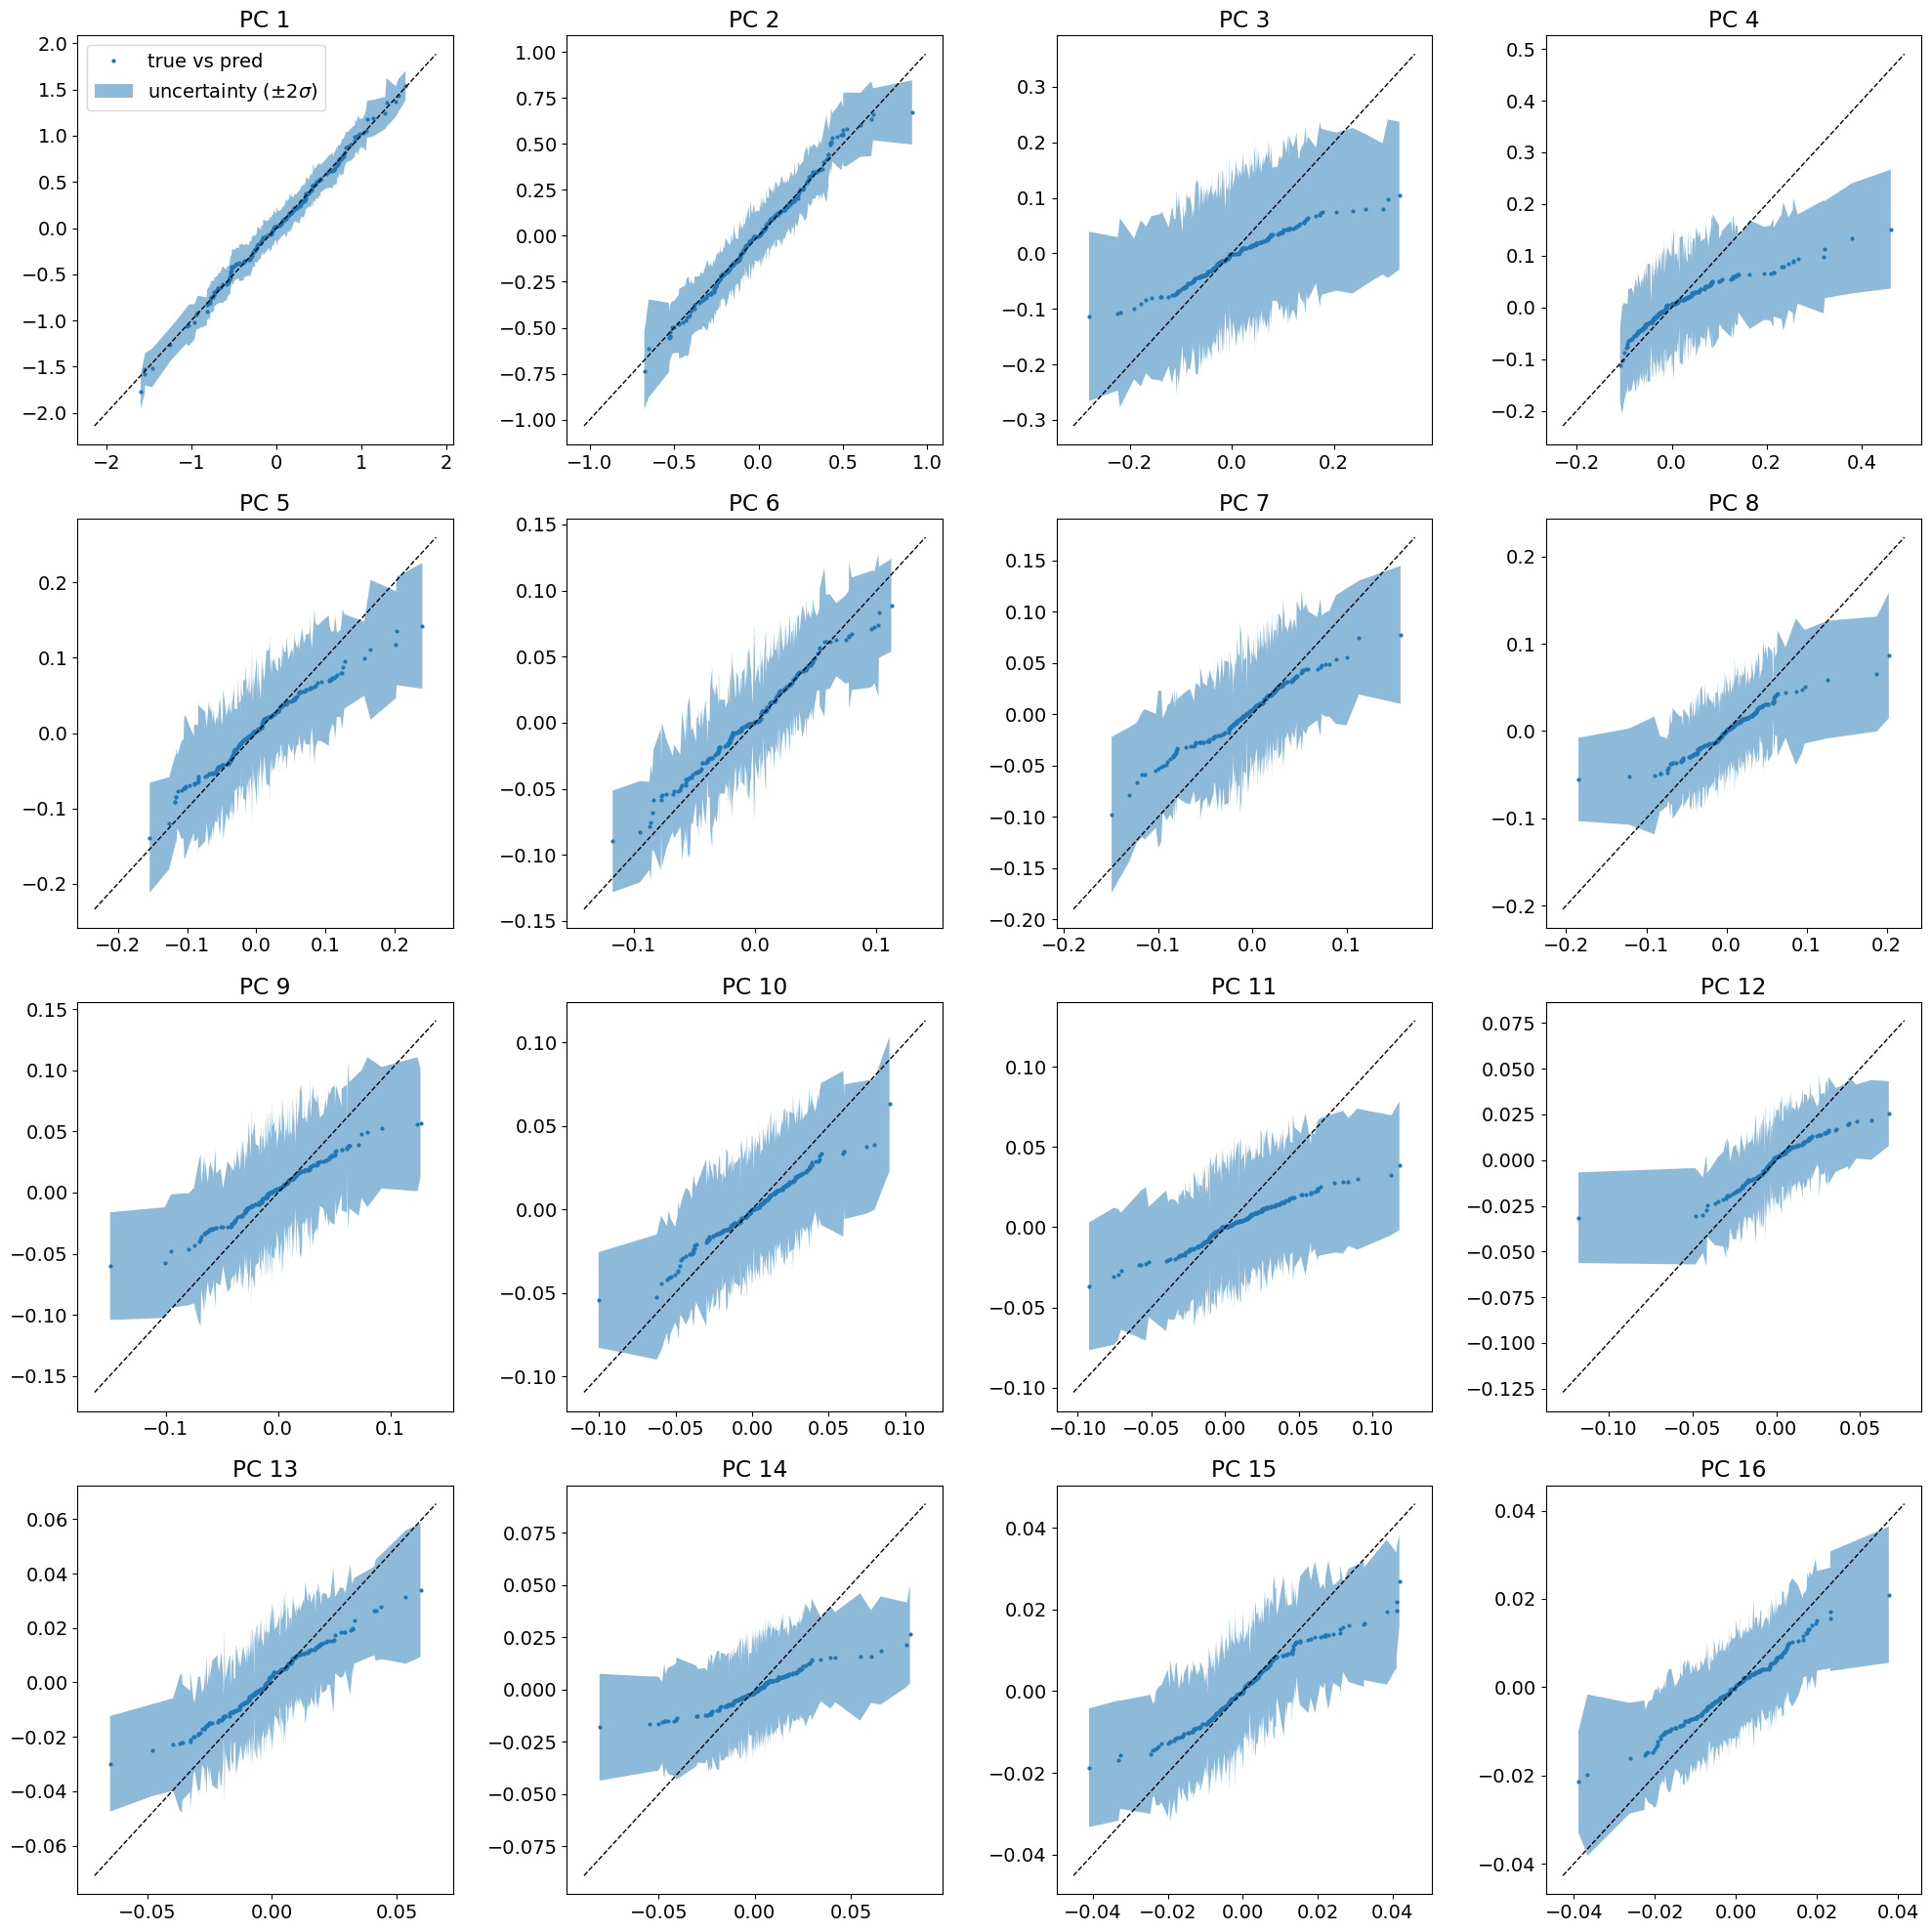

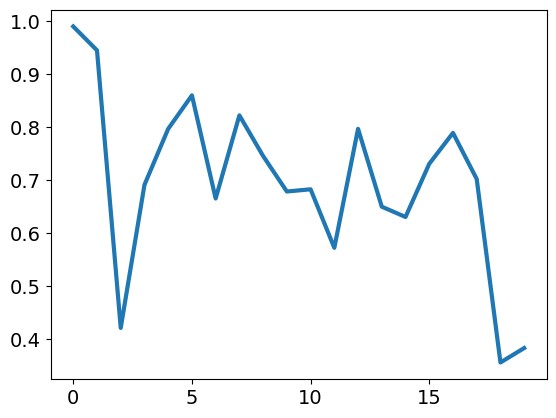

In [11]:
# rc params for line width, font sizes
plt.rcParams["lines.linewidth"] = 3
plt.rcParams["font.size"] = 14

x_test_pca = model.x_test_pca
y_test_pca = model.y_pca.transform(y_test)

fig, ax = plt.subplots(9, 5, figsize=(25, 45))
ax = ax.flatten()


for i in range(m):
    # ax[i].plot(x_train_pca[:, i], y_train_pca[:, i], 'o', label = 'true')
    # ax[i].plot(x_train_pca[:, i][np.argsort(x_train_pca[:, i])], model.y_pred_pca[:, 0, i][np.argsort(x_train_pca[:, i])], '-', label = 'pred', lw = 4)
    # for j in range(n_samples):
    #     train_samples_pca_j = train_samples[:, :, j]
    #     train_samples_j = model.y_pca.transform(train_samples_pca_j)
    #     ax[i].plot(x_train_pca[:, i][np.argsort(x_train_pca[:, i])], train_samples_j[:, i][np.argsort(train_samples_j[:, i])], '-', label = f'sample {j+1}')
    if i > 44:
        break
    ax[i].plot(y_test_pca[:, i][np.argsort(y_test_pca[:, i])], model.y_pred_pca[:, 0, i][np.argsort(model.y_pred_pca[:, 0, i])], 'o', label = 'true vs pred', ms = 2)
    ax[i].fill_between(y_test_pca[:, i][np.argsort(y_test_pca[:, i])], model.y_pred_pca[:, 1, i][np.argsort(model.y_pred_pca[:, 0, i])], model.y_pred_pca[:, 2, i][np.argsort(model.y_pred_pca[:, 0, i])], alpha = 0.5, label=r'uncertainty ($\pm 2\sigma$)')
    # ax[i].plot(y_test_pca[:, i], model.y_pred_pca[:, 1, i], 'o', label = r'true vs (pred - 2$\sigma$)')
    # ax[i].plot(y_test_pca[:, i], model.y_pred_pca[:, 2, i], 'o', label = r'true vs (pred + 2$\sigma$)')
    xlim = ax[i].get_xlim()
    ylim = ax[i].get_ylim()

    min_val = min(xlim[0], ylim[0])
    max_val = max(xlim[1], ylim[1])

    ax[i].plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)
    ax[i].set_title(f'PC {i+1}')
ax[0].legend()
plt.show()

# for thesis

fig, ax = plt.subplots(4, 4, figsize=(20, 20))
ax = ax.flatten()


for i in range(m):
    # ax[i].plot(x_train_pca[:, i], y_train_pca[:, i], 'o', label = 'true')
    # ax[i].plot(x_train_pca[:, i][np.argsort(x_train_pca[:, i])], model.y_pred_pca[:, 0, i][np.argsort(x_train_pca[:, i])], '-', label = 'pred', lw = 4)
    # for j in range(n_samples):
    #     train_samples_pca_j = train_samples[:, :, j]
    #     train_samples_j = model.y_pca.transform(train_samples_pca_j)
    #     ax[i].plot(x_train_pca[:, i][np.argsort(x_train_pca[:, i])], train_samples_j[:, i][np.argsort(train_samples_j[:, i])], '-', label = f'sample {j+1}')
    if i > 15:
        break

    PC_to_plot = i

    ax[i].plot(y_test_pca[:, PC_to_plot][np.argsort(y_test_pca[:, PC_to_plot])], model.y_pred_pca[:, 0, PC_to_plot][np.argsort(model.y_pred_pca[:, 0, PC_to_plot])], 'o', label = 'true vs pred', ms = 2)
    ax[i].fill_between(y_test_pca[:, PC_to_plot][np.argsort(y_test_pca[:, PC_to_plot])], model.y_pred_pca[:, 1, PC_to_plot][np.argsort(model.y_pred_pca[:, 0, PC_to_plot])], model.y_pred_pca[:, 2, PC_to_plot][np.argsort(model.y_pred_pca[:, 0, PC_to_plot])], alpha = 0.5, label=r'uncertainty ($\pm 2\sigma$)')
    # ax[i].plot(y_test_pca[:, i], model.y_pred_pca[:, 1, i], 'o', label = r'true vs (pred - 2$\sigma$)')
    # ax[i].plot(y_test_pca[:, i], model.y_pred_pca[:, 2, i], 'o', label = r'true vs (pred + 2$\sigma$)')
    xlim = ax[i].get_xlim()
    ylim = ax[i].get_ylim()

    min_val = min(xlim[0], ylim[0])
    max_val = max(xlim[1], ylim[1])

    ax[i].plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)
    ax[i].set_title(f'PC {PC_to_plot+1}')
ax[0].legend()
plt.tight_layout()
plt.savefig(f"../figures/{problem}_PCA_pred_vs_true.pdf")
plt.show()

plt.plot([np.corrcoef(y_test_pca[:, i], model.y_pred_pca[:, 0, i])[0, 1] for i in range(m)])

Example test result

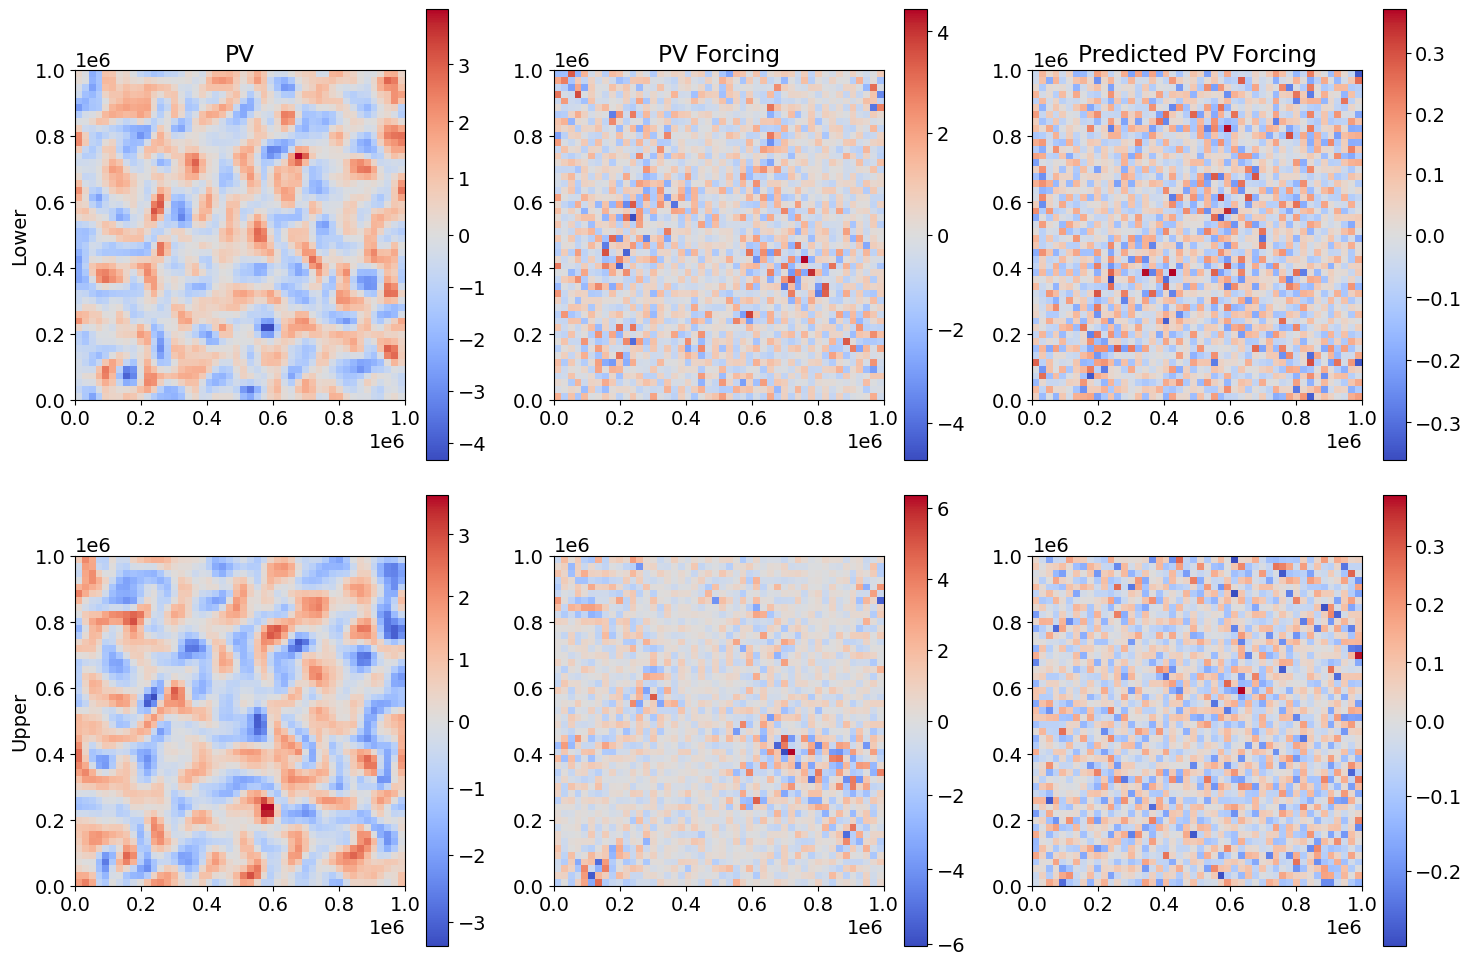

In [ ]:
index_to_plot = 127

y_lims = np.array([min(y_test[index_to_plot, :].min(), y_pred_test[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), y_pred_test[index_to_plot, :].max())])

if problem == 'PV_param':
    fig, ax = plt.subplots(2, 3, figsize = (15, 10))
    ax = ax.flatten()

    im0 = ax[0].imshow(x_test[index_to_plot, :s*s].reshape(s, s), origin='lower', extent=extent, norm=x_norm(), cmap = x_cmap)
    ax[0].set_title("PV")
    fig.colorbar(im0, ax=ax[0])
    ax[0].set_ylabel("Lower")
    im1 = ax[1].imshow(y_test[index_to_plot, :s*s].reshape(s, s), origin='lower', extent=extent, norm=y_norm(), cmap = y_cmap)
    ax[1].set_title("PV Forcing")
    fig.colorbar(im1, ax=ax[1])
    im2 = ax[2].imshow(y_pred_test[index_to_plot, :s*s].reshape(s, s), origin='lower', extent=extent, norm=y_norm(), cmap = y_cmap)
    ax[2].set_title("Predicted PV Forcing")
    fig.colorbar(im2, ax=ax[2])
    im3 = ax[3].imshow(x_test[index_to_plot, s*s:].reshape(s, s), origin='lower', extent=extent, norm=x_norm(), cmap = x_cmap)
    fig.colorbar(im3, ax=ax[3])
    ax[3].set_ylabel("Upper")
    im4 = ax[4].imshow(y_test[index_to_plot, s*s:].reshape(s, s), origin='lower', extent=extent, norm=y_norm(), cmap = y_cmap)
    fig.colorbar(im4, ax=ax[4])
    im5 = ax[5].imshow(y_pred_test[index_to_plot, s*s:].reshape(s, s), origin='lower', extent=extent, norm=y_norm(), cmap = y_cmap)
    fig.colorbar(im5, ax=ax[5])
    plt.tight_layout()
    plt.savefig(f"../figures/{problem}_test_result.pdf")
    plt.show()
else:
    fig, ax = plt.subplots(2, 3, figsize = (15, 10))
    ax = ax.flatten()

    im0 = ax[0].imshow(x_test[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, norm = x_norm(), cmap = x_cmap)
    ax[0].set_title("Test input")
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im0, cax=cax, label=r'U(x, y)')

    im1 = ax[1].imshow(y_test[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, norm=y_norm(), cmap = y_cmap)
    ax[1].set_title("Ground truth output")
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im1, cax=cax, label=r'V(x, y)')

    im2 = ax[2].imshow(y_pred_test[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, norm=y_norm(), cmap = y_cmap)
    ax[2].set_title("Mean prediction")
    divider = make_axes_locatable(ax[2])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im2, cax=cax, label=r'V(x, y)')

    for i in range(3):
        imi = ax[i+3].imshow(test_samples[index_to_plot, :, i].reshape(s, s), origin='lower', extent=extent, norm=y_norm(), cmap = y_cmap)
        ax[i+3].set_title(f"Sample {i+1}")
        divider = make_axes_locatable(ax[i+3])
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = fig.colorbar(imi, cax=cax, label=r'V(x, y)')
        
                # ax[i].legend()
    plt.tight_layout()
    plt.savefig(f"../figures/{problem}_test_result.pdf")
    plt.show()

## Analyse uncertainty

In [32]:
print(test_samples.shape)

test_samples_mean = np.mean(test_samples, axis = 2)
test_samples_std = np.std(test_samples, axis = 2)

(430, 4608, 100)


plot test result with uncertainty

(430, 4608)


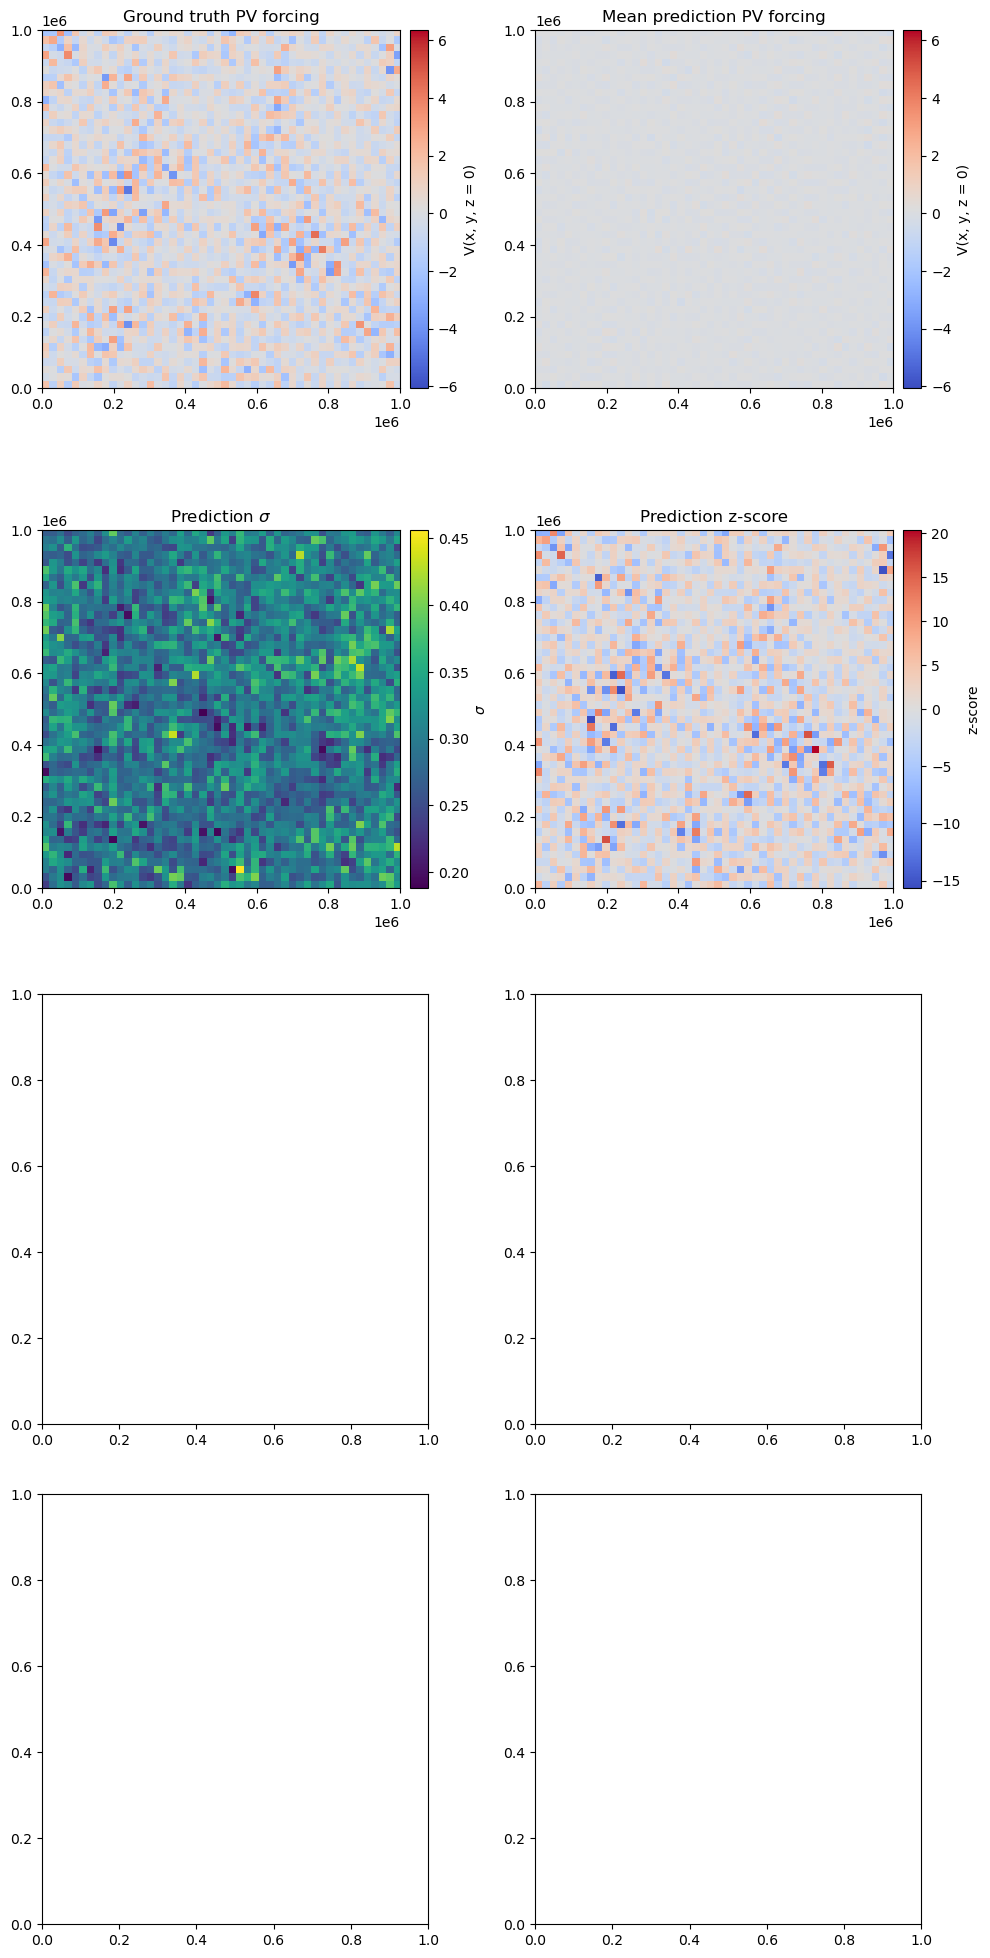

mean NLPD: inf
mean adapted NLPD: inf
(860, 2116)
(832287,)
percentage of z-scores within 95% confidence interval: 0.45736086077284915


/var/folders/pq/m1s3wh755x9fhcy2gq520_3r0000gn/T/ipykernel_1048/1728237726.py:102: RuntimeWarning: divide by zero encountered in log
  NLPD = -np.sum(np.log(probabilities), axis = 1)
/var/folders/pq/m1s3wh755x9fhcy2gq520_3r0000gn/T/ipykernel_1048/1728237726.py:107: RuntimeWarning: divide by zero encountered in log
  adapted_NLPD = -np.mean(np.log(probabilities), axis = 1)


In [41]:
def z_score_to_pdf(z):
    """
    Calculate the probability density function (PDF) value for a given z-score
    in the standard normal distribution.

    Parameters:
    z (float): The z-score for which to calculate the PDF value.

    Returns:
    float: The PDF value corresponding to the given z-score.
    """
    pdf_value = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * z**2)
    return pdf_value

index_to_plot = 127

y_lims = np.array([min(y_test[index_to_plot, :].min(), test_samples_mean[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), test_samples_mean[index_to_plot, :].max())])

if problem == 'PV_param':
    fig, ax = plt.subplots(4, 2, figsize = (10, 20))
    ax = ax.flatten()

    im0 = ax[0].imshow(y_test[index_to_plot, :s*s].reshape(s, s), origin='lower', extent=extent, norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]), cmap = y_cmap)
    ax[0].set_title("Ground truth PV forcing")
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im0, cax=cax, label=r'V(x, y, z = 0)')

    im1 = ax[1].imshow(test_samples_mean[index_to_plot, :s*s].reshape(s, s), origin='lower', extent=extent, norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]), cmap = y_cmap)
    ax[1].set_title("Mean prediction PV forcing")
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im1, cax=cax, label=r'V(x, y, z = 0)')

    im2 = ax[2].imshow(test_samples_std[index_to_plot, :s*s].reshape(s, s), origin='lower', extent=extent)
    ax[2].set_title(r"Prediction $\sigma$")
    divider = make_axes_locatable(ax[2])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im2, cax=cax, label=r'$\sigma$')

    z_scores = (y_test - test_samples_mean) / test_samples_std
    print(z_scores.shape)

    im3 = ax[3].imshow(z_scores[index_to_plot, :s*s].reshape(s, s), origin='lower', extent=extent, cmap = 'coolwarm', norm = TwoSlopeNorm(vcenter=0))
    ax[3].set_title(f"Prediction z-score")
    divider = make_axes_locatable(ax[3])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im3, cax=cax, label=r'z-score')

    im4 = ax[4].imshow(y_test[index_to_plot, s*s:].reshape(s, s), origin='lower', extent=extent, norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]), cmap = y_cmap)
    ax[4].set_title("Ground truth PV forcing")
    divider = make_axes_locatable(ax[4])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im4, cax=cax, label=r'V(x, y, z = 0)')

    im5 = ax[5].imshow(test_samples_mean[index_to_plot, s*s:].reshape(s, s), origin='lower', extent=extent, norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]), cmap = y_cmap)
    ax[5].set_title("Mean prediction PV forcing")
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im5, cax=cax, label=r'V(x, y, z = 0)')

    im6 = ax[6].imshow(test_samples_std[index_to_plot, s*s:].reshape(s, s), origin='lower', extent=extent)
    ax[6].set_title(r"Prediction $\sigma$")
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im6, cax=cax, label=r'$\sigma$')

    im7 = ax[7].imshow(z_scores[index_to_plot, s*s:].reshape(s, s), origin='lower', extent=extent, cmap = 'coolwarm', norm = TwoSlopeNorm(vcenter=0))
    ax[7].set_title(f"Prediction z-score")
    divider = make_axes_locatable(ax[7])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im7, cax=cax, label=r'z-score')

    plt.tight_layout()
    plt.savefig(f"../figures/{problem}_test_result_uncertainty.pdf")
    plt.show()

else:
    fig, ax = plt.subplots(2, 2, figsize = (10, 10))
    ax = ax.flatten()

    im0 = ax[0].imshow(y_test[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]), cmap = y_cmap)
    ax[0].set_title("Ground truth output")
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im0, cax=cax, label=r'V(x, y)')

    im1 = ax[1].imshow(test_samples_mean[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]), cmap = y_cmap)
    ax[1].set_title(f"Mean prediction")
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im1, cax=cax, label=r'V(x, y)')

    im2 = ax[2].imshow(test_samples_std[index_to_plot, :].reshape(s, s), origin='lower', extent=extent)
    ax[2].set_title(r"Prediction $\sigma$")
    divider = make_axes_locatable(ax[2])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im2, cax=cax, label=r'$\sigma$')

    z_scores = (y_test - test_samples_mean) / test_samples_std
    z_scores = z_scores.reshape(-1, s, s)
    z_scores[:, 0, :] = 0
    z_scores[:, -1, :] = 0
    z_scores[:, :, 0] = 0
    z_scores[:, :, -1] = 0

    im3 = ax[3].imshow(z_scores[index_to_plot], origin='lower', extent=extent, cmap = 'coolwarm', norm = TwoSlopeNorm(vcenter=0))
    ax[3].set_title(f"Prediction z-score")
    divider = make_axes_locatable(ax[3])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im3, cax=cax, label=r'z-score')

    plt.tight_layout()
    plt.savefig(f"../figures/{problem}_test_result_uncertainty.pdf")
    plt.show()

# calculate NLPD
# reshape to remove nans
y_test_re, test_samples_mean_re, test_samples_std_re = y_test.reshape(-1, s, s)[:, 1:-1, 1:-1].reshape(-1, (s-2)*(s-2)), test_samples_mean.reshape(-1, s, s)[:, 1:-1, 1:-1].reshape(-1, (s-2)*(s-2)), test_samples_std.reshape(-1, s, s)[:, 1:-1, 1:-1].reshape(-1, (s-2)*(s-2))
z_scores_re = (y_test_re - test_samples_mean_re) / test_samples_std_re
# print(z_scores.shape)
probabilities = z_score_to_pdf(z_scores_re)
# print(probabilities.shape)
# print(probabilities)
# print(probabilities.min(), probabilities.max())
NLPD = -np.sum(np.log(probabilities), axis = 1)
# print(NLPD)
mean_NLPD = np.mean(NLPD)
print(f'mean NLPD: {mean_NLPD}')

adapted_NLPD = -np.mean(np.log(probabilities), axis = 1)
mean_adapted_NLPD = np.mean(adapted_NLPD)
print(f'mean adapted NLPD: {mean_adapted_NLPD}')

z_scores_within_conf = z_scores_re[abs(z_scores_re) - 1.96 < 0]
print(z_scores_re.shape)
print(z_scores_within_conf.shape)

print(f'percentage of z-scores within 95% confidence interval: {z_scores_within_conf.shape[0]/(z_scores_re.shape[0]*z_scores_re.shape[1])}')


Plot example test results with uncertainty and pointwise errors (Figures 4.3-5)

(430, 4608)


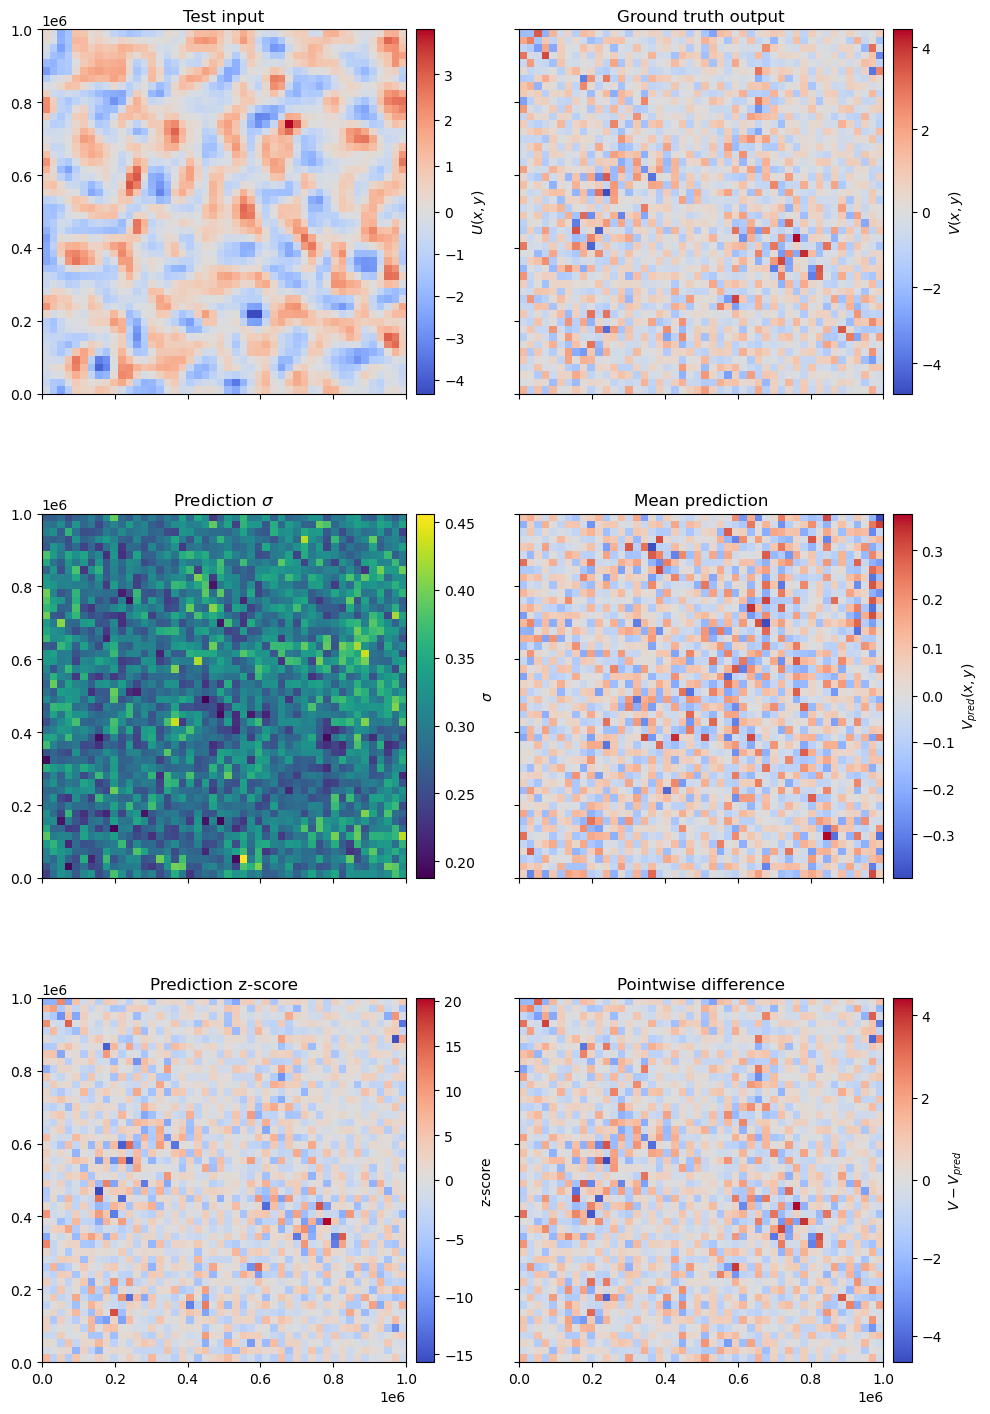

In [57]:
# for thesis

print(z_scores.shape)

index_to_plot = 127

if problem == 'PV_param':
    fig, ax = plt.subplots(3, 2, figsize=(10, 15), sharex=True, sharey=True)
    ax = ax.flatten()

    im0 = ax[0//2].imshow(x_test[index_to_plot, :s*s].reshape(s, s), origin='lower', extent=extent, norm = x_norm(), cmap = x_cmap)
    # fig.colorbar(im0, ax=ax[0//2])
    ax[0//2].set_title("Test input")
    divider = make_axes_locatable(ax[0//2])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im0, cax=cax, label=r'$U(x, y)$')

    # im1 = ax[1].imshow(x_test[index_to_plot, s*s:].reshape(s, s), origin='lower', extent=extent, norm = x_norm(), cmap = x_cmap)
    # ax[1].set_title("Test input")
    # fig.colorbar(im1, ax=ax[1])
    # divider = make_axes_locatable(ax[1])
    # cax = divider.append_axes("right", size="5%", pad=0.1)
    # cbar = fig.colorbar(im1, cax=cax, label=r'$U(x, y)$')

    im2 = ax[2//2].imshow(y_test[index_to_plot, :s*s].reshape(s, s), origin='lower', extent=extent, norm=y_norm(), cmap = y_cmap)
    # fig.colorbar(im2, ax=ax[2//2])
    ax[2//2].set_title("Ground truth output")
    divider = make_axes_locatable(ax[2//2])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im2, cax=cax, label=r'$V(x, y)$')

    # im3 = ax[3].imshow(y_test[index_to_plot, s*s:].reshape(s, s), origin='lower', extent=extent, norm=y_norm(), cmap = y_cmap)
    # fig.colorbar(im3, ax=ax[3])
    # ax[3].set_title("Ground truth output")
    # divider = make_axes_locatable(ax[3])
    # cax = divider.append_axes("right", size="5%", pad=0.1)
    # cbar = fig.colorbar(im3, cax=cax, label=r'$V(x, y)$')

    im4 = ax[4//2].imshow(test_samples_std[index_to_plot, :s*s].reshape(s, s), origin='lower', extent=extent)
    # fig.colorbar(im4, ax=ax[4//2])
    ax[4//2].set_title(r"Prediction $\sigma$")
    divider = make_axes_locatable(ax[4//2])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im4, cax=cax, label=r'$\sigma$')

    # im5 = ax[5].imshow(test_samples_std[index_to_plot, s*s:].reshape(s, s), origin='lower', extent=extent)
    # fig.colorbar(im5, ax=ax[5])
    # ax[5].set_title(r"Prediction $\sigma$")
    # divider = make_axes_locatable(ax[5])
    # cax = divider.append_axes("right", size="5%", pad=0.1)
    # cbar = fig.colorbar(im5, cax=cax, label=r'$\sigma$')

    im6 = ax[6//2].imshow(y_pred_test[index_to_plot, :s*s].reshape(s, s), origin='lower', extent=extent, norm=y_norm(), cmap = y_cmap)
    # fig.colorbar(im6, ax=ax[6//2])
    ax[6//2].set_title("Mean prediction")
    divider = make_axes_locatable(ax[6//2])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im6, cax=cax, label=r'$V_{pred}(x, y)$')

    # im7 = ax[7].imshow(y_pred_test[index_to_plot, s*s:].reshape(s, s), origin='lower', extent=extent, norm=y_norm(), cmap = y_cmap)
    # fig.colorbar(im7, ax=ax[7])
    # ax[7].set_title("Mean prediction")
    # divider = make_axes_locatable(ax[7])
    # cax = divider.append_axes("right", size="5%", pad=0.1)
    # cbar = fig.colorbar(im7, cax=cax, label=r'$V_{pred}(x, y)$')

    im8 = ax[8//2].imshow(z_scores[index_to_plot, :s*s].reshape(s, s), origin='lower', extent=extent, cmap = 'coolwarm', norm = TwoSlopeNorm(vcenter=0))
    # fig.colorbar(im8, ax=ax[8//2])
    ax[8//2].set_title(f"Prediction z-score")
    divider = make_axes_locatable(ax[8//2])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im8, cax=cax, label=r'z-score')

    # im9 = ax[9].imshow(z_scores[index_to_plot, s*s:].reshape(s, s), origin='lower', extent=extent, cmap = 'coolwarm', norm = TwoSlopeNorm(vcenter=0))
    # fig.colorbar(im9, ax=ax[9])
    # ax[9].set_title(f"Prediction z-score")
    # divider = make_axes_locatable(ax[9])
    # cax = divider.append_axes("right", size="5%", pad=0.1)
    # cbar = fig.colorbar(im9, cax=cax, label=r'z-score')

    im10 = ax[10//2].imshow(y_test[index_to_plot, :s*s].reshape(s, s) - y_pred_test[index_to_plot, :s*s].reshape(s, s), origin='lower', extent=extent, cmap = 'coolwarm', norm = TwoSlopeNorm(vcenter=0))
    # fig.colorbar(im10, ax=ax[10//2])
    ax[10//2].set_title(f"Pointwise difference")
    divider = make_axes_locatable(ax[10//2])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im10, cax=cax, label=r'$V - V_{pred}$')

    # im11 = ax[11].imshow(y_test[index_to_plot, s*s:].reshape(s, s) - y_pred_test[index_to_plot, s*s:].reshape(s, s), origin='lower', extent=extent, cmap = 'coolwarm', norm = TwoSlopeNorm(vcenter=0))
    # fig.colorbar(im11, ax=ax[11])
    # ax[11].set_title(f"Pointwise difference")
    # divider = make_axes_locatable(ax[11])
    # cax = divider.append_axes("right", size="5%", pad=0.1)
    # cbar = fig.colorbar(im11, cax=cax, label=r'$V - V_{pred}$')

    plt.tight_layout()
    plt.savefig(f"../figures/{problem}_FULL_test_result.pdf")
    plt.show()


else:
    fig, ax = plt.subplots(3, 2, figsize=(10, 15))
    ax = ax.flatten()

    im0 = ax[0].imshow(x_test[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, norm = x_norm(), cmap = x_cmap)
    ax[0].set_title("Test input")
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im0, cax=cax, label=r'$U(x, y)$')

    im1 = ax[1].imshow(y_test[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, norm=y_norm(), cmap = y_cmap)
    ax[1].set_title("Ground truth output")
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im1, cax=cax, label=r'$V(x, y)$')

    im2 = ax[2].imshow(test_samples_std[index_to_plot, :].reshape(s, s), origin='lower', extent=extent)
    ax[2].set_title(r"Prediction $\sigma$")
    divider = make_axes_locatable(ax[2])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im2, cax=cax, label=r'$\sigma$')

    im3 = ax[3].imshow(y_pred_test[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, norm=y_norm(), cmap = y_cmap)
    ax[3].set_title("Mean prediction")
    divider = make_axes_locatable(ax[3])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im3, cax=cax, label=r'$V_{pred}(x, y)$')

    im4 = ax[4].imshow(z_scores[index_to_plot].reshape(s, s), origin='lower', extent=extent, cmap = 'coolwarm', norm = TwoSlopeNorm(vcenter=0))
    ax[4].set_title(f"Prediction z-score")
    divider = make_axes_locatable(ax[4])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im4, cax=cax, label=r'z-score')

    im5 = ax[5].imshow(y_test[index_to_plot, :].reshape(s, s) - y_pred_test[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, cmap = 'coolwarm', norm = TwoSlopeNorm(vcenter=0))
    ax[5].set_title(f"Pointwise difference")
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im5, cax=cax, label=r'$V - V_{pred}$')

    plt.tight_layout()
    plt.savefig(f"../figures/{problem}_FULL_test_result.pdf")
    plt.show()

Linear regression baseline

In [ ]:
results = []
for Ntrain in [1000]:
    for N_components in [128, 256, 512, 1024]:
        print(Ntrain, N_components)
        Ytr = y_train
        Xtr = x_train
        pca = PCA(n_components=min(N_components,Ntrain))
        Xtr = pca.fit_transform(Xtr)
        reg = LinearRegression(n_jobs = -1).fit(Xtr, Ytr)
        #Ypred Ypredtr = reg.predict(Xtr)
        Ypredtr = reg.predict(Xtr)
        train_error = np.mean(np.linalg.norm(Ypredtr-Ytr, axis = 1)/np.linalg.norm(Ytr, axis = 1))
        Xtest = x_test
        Ytest = y_test
        Xtest = pca.transform(Xtest)
        Ypred = reg.predict(Xtest)
        test_error = np.mean(np.linalg.norm(Ypred-Ytest, axis = 1)/np.linalg.norm(Ytest, axis = 1))
        print(train_error, test_error)
        results.append([Ntrain, N_components, train_error, test_error])

        index_to_plot = 125

        y_lims = np.array([min(y_test[index_to_plot, :].min(), Ypred[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), Ypred[index_to_plot, :].max())])

        fig, ax = plt.subplots(2, 2, figsize = (10, 10))
        ax = ax.flatten()
        im0 = ax[0].imshow(x_test[index_to_plot, :].reshape(s, s), origin='lower', extent=extent)
        ax[0].set_title("x_test")
        im1 = ax[1].imshow(y_test[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
        ax[1].set_title("y_test")
        im2 = ax[2].imshow(Ypred[index_to_plot, :].reshape(s, s), origin='lower', extent=extent, norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
        ax[2].set_title("y_pred_test")
        plt.show()

results = np.array(results)